# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [1]:
# installs the tutorial package
!pip install m3_learning

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

from m3_learning.util.data_generators import generate_data
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function


# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [3]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255

## Displays the image


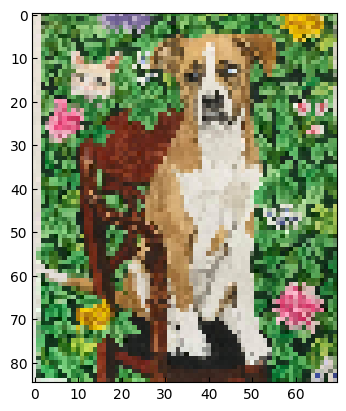

In [4]:
plt.imshow(image)

## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [5]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )

In [6]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3), length=10, function=non_linear_fn)

In [7]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)

## Plots the generated data


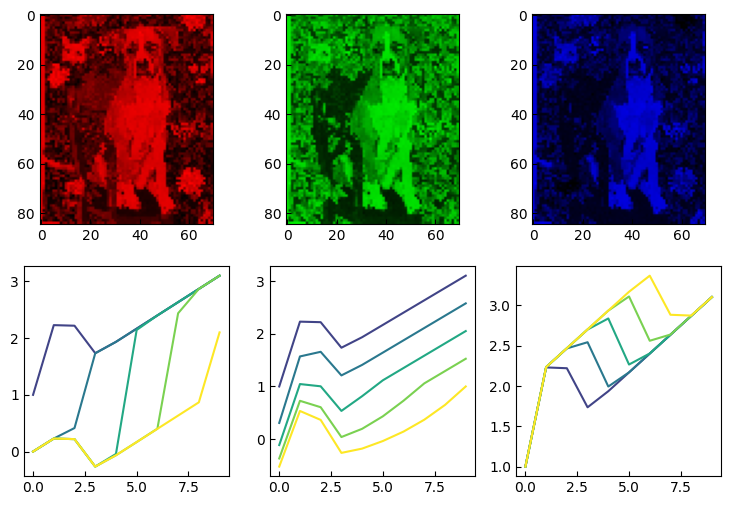

In [8]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)

## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [9]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x

### Builds the autoencoder


In [10]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted

### Instantiates the model


In [11]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

You are running on a cuda


In [12]:
try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [13]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)

### Trains the model


In [14]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 0, Train Loss: 2.3032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 1, Train Loss: 2.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 452.39it/s]

Epoch 2, Train Loss: 2.0240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 3, Train Loss: 1.8940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 4, Train Loss: 1.7652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 5, Train Loss: 1.6400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 6, Train Loss: 1.5155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 7, Train Loss: 1.3920
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 8, Train Loss: 1.2732
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 9, Train Loss: 1.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 10, Train Loss: 1.0510
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 11, Train Loss: 0.9496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.85it/s]

Epoch 12, Train Loss: 0.8558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 13, Train Loss: 0.7679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 14, Train Loss: 0.6882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 15, Train Loss: 0.6171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 16, Train Loss: 0.5517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 17, Train Loss: 0.4933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 18, Train Loss: 0.4414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.25it/s]

Epoch 19, Train Loss: 0.3964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 20, Train Loss: 0.3563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 21, Train Loss: 0.3214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 22, Train Loss: 0.2910
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.80it/s]

Epoch 23, Train Loss: 0.2649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 24, Train Loss: 0.2429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 25, Train Loss: 0.2241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 26, Train Loss: 0.2086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 27, Train Loss: 0.1954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 28, Train Loss: 0.1842
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 29, Train Loss: 0.1751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 30, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 31, Train Loss: 0.1601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 32, Train Loss: 0.1550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 33, Train Loss: 0.1500
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 34, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 35, Train Loss: 0.1423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 36, Train Loss: 0.1390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 37, Train Loss: 0.1358
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 38, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.82it/s]

Epoch 39, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 40, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 41, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 42, Train Loss: 0.1238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 43, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 44, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.80it/s]

Epoch 45, Train Loss: 0.1176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 46, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 47, Train Loss: 0.1138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 48, Train Loss: 0.1116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 49, Train Loss: 0.1099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.85it/s]

Epoch 50, Train Loss: 0.1081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.85it/s]

Epoch 51, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 52, Train Loss: 0.1046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 53, Train Loss: 0.1028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.88it/s]

Epoch 54, Train Loss: 0.1010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 55, Train Loss: 0.0993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 56, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 57, Train Loss: 0.0960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 58, Train Loss: 0.0942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 59, Train Loss: 0.0924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 60, Train Loss: 0.0907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 61, Train Loss: 0.0893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 62, Train Loss: 0.0875
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 63, Train Loss: 0.0860
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 64, Train Loss: 0.0846
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 65, Train Loss: 0.0828
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 66, Train Loss: 0.0811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 67, Train Loss: 0.0797
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 68, Train Loss: 0.0781
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 69, Train Loss: 0.0767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 70, Train Loss: 0.0752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 71, Train Loss: 0.0738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 72, Train Loss: 0.0722
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 73, Train Loss: 0.0709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 74, Train Loss: 0.0695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 75, Train Loss: 0.0682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 76, Train Loss: 0.0668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 77, Train Loss: 0.0655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 78, Train Loss: 0.0641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 79, Train Loss: 0.0628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 80, Train Loss: 0.0616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 81, Train Loss: 0.0604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 82, Train Loss: 0.0592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 83, Train Loss: 0.0580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 84, Train Loss: 0.0569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 85, Train Loss: 0.0558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 86, Train Loss: 0.0547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 87, Train Loss: 0.0536
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 88, Train Loss: 0.0526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 89, Train Loss: 0.0515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 90, Train Loss: 0.0504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 91, Train Loss: 0.0495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 92, Train Loss: 0.0486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 93, Train Loss: 0.0477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 94, Train Loss: 0.0467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 95, Train Loss: 0.0458
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 96, Train Loss: 0.0450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 97, Train Loss: 0.0442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 98, Train Loss: 0.0434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 99, Train Loss: 0.0426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 100, Train Loss: 0.0418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.80it/s]

Epoch 101, Train Loss: 0.0411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 102, Train Loss: 0.0403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 103, Train Loss: 0.0396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 104, Train Loss: 0.0389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 105, Train Loss: 0.0382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.24it/s]

Epoch 106, Train Loss: 0.0375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 107, Train Loss: 0.0369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 108, Train Loss: 0.0362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 109, Train Loss: 0.0357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 110, Train Loss: 0.0351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 111, Train Loss: 0.0345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 112, Train Loss: 0.0340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 113, Train Loss: 0.0334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 114, Train Loss: 0.0329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 115, Train Loss: 0.0324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 116, Train Loss: 0.0318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 117, Train Loss: 0.0313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.24it/s]

Epoch 118, Train Loss: 0.0309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 119, Train Loss: 0.0304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 120, Train Loss: 0.0299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 121, Train Loss: 0.0295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 122, Train Loss: 0.0291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 123, Train Loss: 0.0287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 124, Train Loss: 0.0282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 125, Train Loss: 0.0279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 126, Train Loss: 0.0275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 127, Train Loss: 0.0271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 128, Train Loss: 0.0267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 129, Train Loss: 0.0264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 130, Train Loss: 0.0260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 131, Train Loss: 0.0256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 132, Train Loss: 0.0253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 133, Train Loss: 0.0250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 134, Train Loss: 0.0247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 135, Train Loss: 0.0244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 136, Train Loss: 0.0241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 137, Train Loss: 0.0238
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 138, Train Loss: 0.0235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 139, Train Loss: 0.0232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 140, Train Loss: 0.0229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 141, Train Loss: 0.0227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 142, Train Loss: 0.0223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 143, Train Loss: 0.0221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 144, Train Loss: 0.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 145, Train Loss: 0.0216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 146, Train Loss: 0.0213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 147, Train Loss: 0.0211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 148, Train Loss: 0.0208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 149, Train Loss: 0.0206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 150, Train Loss: 0.0204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 151, Train Loss: 0.0202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 152, Train Loss: 0.0199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 153, Train Loss: 0.0197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 154, Train Loss: 0.0194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 155, Train Loss: 0.0192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 156, Train Loss: 0.0190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 157, Train Loss: 0.0188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 158, Train Loss: 0.0186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 159, Train Loss: 0.0184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 160, Train Loss: 0.0182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 161, Train Loss: 0.0180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 162, Train Loss: 0.0178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 163, Train Loss: 0.0175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 164, Train Loss: 0.0173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 165, Train Loss: 0.0172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 166, Train Loss: 0.0170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 167, Train Loss: 0.0168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 168, Train Loss: 0.0166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 169, Train Loss: 0.0164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 170, Train Loss: 0.0162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 171, Train Loss: 0.0160
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 172, Train Loss: 0.0159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 173, Train Loss: 0.0156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 174, Train Loss: 0.0155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 175, Train Loss: 0.0153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 176, Train Loss: 0.0151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.26it/s]

Epoch 177, Train Loss: 0.0150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 178, Train Loss: 0.0149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 179, Train Loss: 0.0146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 180, Train Loss: 0.0144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 181, Train Loss: 0.0143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 182, Train Loss: 0.0141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 183, Train Loss: 0.0140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 184, Train Loss: 0.0138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 185, Train Loss: 0.0136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 186, Train Loss: 0.0135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 187, Train Loss: 0.0133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 188, Train Loss: 0.0131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 189, Train Loss: 0.0130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 190, Train Loss: 0.0128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 191, Train Loss: 0.0127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 192, Train Loss: 0.0126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 193, Train Loss: 0.0124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 194, Train Loss: 0.0122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 195, Train Loss: 0.0121
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 196, Train Loss: 0.0120
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 197, Train Loss: 0.0118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 198, Train Loss: 0.0116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 199, Train Loss: 0.0115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 200, Train Loss: 0.0114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 201, Train Loss: 0.0112
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 202, Train Loss: 0.0111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 203, Train Loss: 0.0109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.24it/s]

Epoch 204, Train Loss: 0.0108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 205, Train Loss: 0.0107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 206, Train Loss: 0.0105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 207, Train Loss: 0.0104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 208, Train Loss: 0.0102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 209, Train Loss: 0.0101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 210, Train Loss: 0.0100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 211, Train Loss: 0.0099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.24it/s]

Epoch 212, Train Loss: 0.0097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 213, Train Loss: 0.0096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 214, Train Loss: 0.0095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 215, Train Loss: 0.0094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 216, Train Loss: 0.0092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 217, Train Loss: 0.0091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 218, Train Loss: 0.0090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 219, Train Loss: 0.0089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 220, Train Loss: 0.0087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 221, Train Loss: 0.0086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 222, Train Loss: 0.0085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 223, Train Loss: 0.0084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 224, Train Loss: 0.0083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 225, Train Loss: 0.0082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 226, Train Loss: 0.0080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 227, Train Loss: 0.0079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 228, Train Loss: 0.0078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 229, Train Loss: 0.0077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 230, Train Loss: 0.0076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 231, Train Loss: 0.0075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 232, Train Loss: 0.0073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 233, Train Loss: 0.0072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 234, Train Loss: 0.0071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 235, Train Loss: 0.0070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 236, Train Loss: 0.0069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 237, Train Loss: 0.0069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 238, Train Loss: 0.0067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 239, Train Loss: 0.0066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 240, Train Loss: 0.0066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 241, Train Loss: 0.0065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 242, Train Loss: 0.0064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 243, Train Loss: 0.0062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 244, Train Loss: 0.0061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 245, Train Loss: 0.0061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 246, Train Loss: 0.0060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 247, Train Loss: 0.0059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 248, Train Loss: 0.0058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 249, Train Loss: 0.0057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 250, Train Loss: 0.0056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 251, Train Loss: 0.0055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 252, Train Loss: 0.0055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 253, Train Loss: 0.0054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 254, Train Loss: 0.0053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 255, Train Loss: 0.0052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 256, Train Loss: 0.0051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 257, Train Loss: 0.0050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 258, Train Loss: 0.0050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.24it/s]

Epoch 259, Train Loss: 0.0049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 260, Train Loss: 0.0048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 261, Train Loss: 0.0047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 262, Train Loss: 0.0046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 263, Train Loss: 0.0046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 264, Train Loss: 0.0045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 265, Train Loss: 0.0044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 266, Train Loss: 0.0044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 267, Train Loss: 0.0043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 268, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 269, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 270, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 271, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 272, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 273, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 380.00it/s]

Epoch 274, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 275, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 276, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 277, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 278, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 279, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 280, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 281, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 282, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 283, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 284, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 285, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 286, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 287, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 288, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 289, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.25it/s]

Epoch 290, Train Loss: 0.0029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 291, Train Loss: 0.0029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 292, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 293, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 294, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 295, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 296, Train Loss: 0.0026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 297, Train Loss: 0.0026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 298, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 299, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 300, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 301, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 302, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 303, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 304, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 305, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 306, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 307, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 308, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 309, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 310, Train Loss: 0.0020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 311, Train Loss: 0.0020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 312, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 313, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 314, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 315, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 316, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 317, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 318, Train Loss: 0.0017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 319, Train Loss: 0.0017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 320, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 321, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 322, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 323, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 324, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 325, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 326, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 327, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 328, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 329, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 330, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 331, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 332, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 333, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 334, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 335, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 336, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 337, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 338, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 339, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 340, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 341, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 342, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 343, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 344, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 345, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 346, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 347, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 348, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 349, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 350, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 351, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 352, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 353, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 354, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 355, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 356, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 357, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 358, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 359, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 360, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.85it/s]

Epoch 361, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 362, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 363, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 364, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 365, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 366, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 367, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 368, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 369, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 370, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 371, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 372, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 373, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 374, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 375, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 376, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 377, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 378, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 379, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 380, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 381, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 382, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 383, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 384, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 385, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 386, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 387, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 388, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 389, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 390, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 391, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.20it/s]

Epoch 392, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 393, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 394, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 395, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.82it/s]

Epoch 396, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 397, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 398, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 399, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 400, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 401, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.87it/s]

Epoch 402, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 403, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 404, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 405, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 406, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 407, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 408, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 409, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 410, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 411, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 412, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 413, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 414, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 415, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 416, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 417, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 418, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 419, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 420, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 421, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 422, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 423, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 424, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 425, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 426, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 427, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 428, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 429, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 430, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 431, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 432, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 433, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 434, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 435, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 436, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 437, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 438, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 439, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 440, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 441, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.84it/s]

Epoch 442, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 443, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 444, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.24it/s]

Epoch 445, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 446, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 447, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 448, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 449, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 450, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 451, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.82it/s]

Epoch 452, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 453, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 454, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 455, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 456, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 457, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 458, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 459, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 460, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 461, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 462, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 463, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 464, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 465, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 466, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 467, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 468, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 469, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 470, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 471, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 472, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 473, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 474, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 475, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 476, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 477, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 478, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 479, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 480, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.07it/s]

Epoch 481, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 482, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 483, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 484, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 485, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 486, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 487, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 488, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 489, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 490, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 491, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 492, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 493, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 494, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 495, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 496, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 497, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 498, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 499, Train Loss: 0.0001
.............................


### Evaluates the model after training


In [15]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

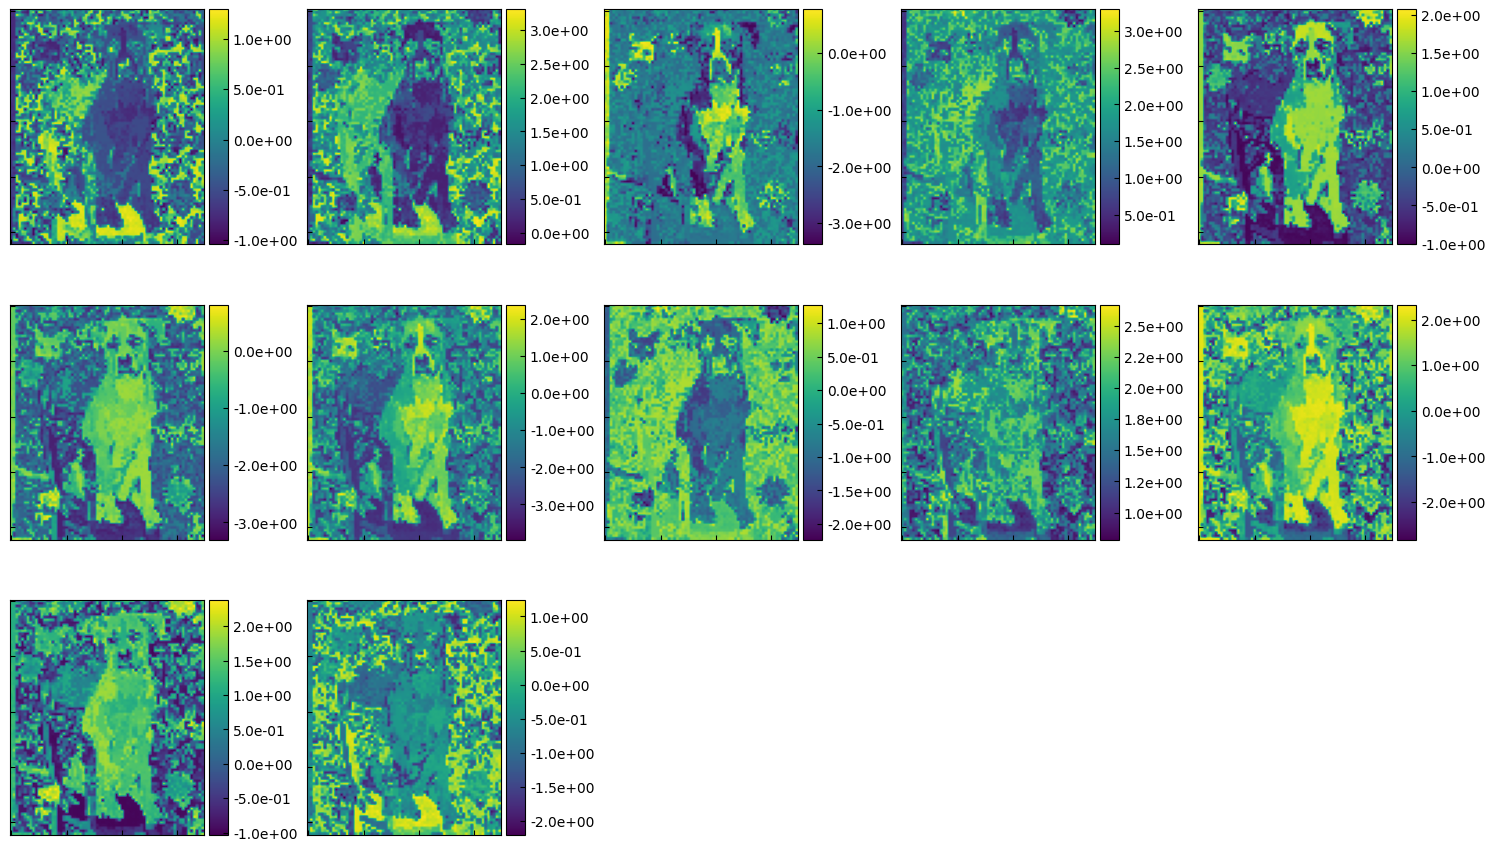

In [16]:
embedding_maps(encode, image)

- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [17]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [18]:
summary(model, ((X_train.shape[1:])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [19]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)

### Trains the model


In [20]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 0, Train Loss: 2.3367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 1, Train Loss: 2.2750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 2, Train Loss: 2.2174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 345.46it/s]

Epoch 3, Train Loss: 2.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.38it/s]

Epoch 4, Train Loss: 2.1008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 5, Train Loss: 2.0443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 372.55it/s]

Epoch 6, Train Loss: 1.9859
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 379.99it/s]

Epoch 7, Train Loss: 1.9263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 345.45it/s]

Epoch 8, Train Loss: 1.8688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 9, Train Loss: 1.8143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 10, Train Loss: 1.7565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 372.56it/s]

Epoch 11, Train Loss: 1.7003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 12, Train Loss: 1.6473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 13, Train Loss: 1.5919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 14, Train Loss: 1.5402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 15, Train Loss: 1.4904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 16, Train Loss: 1.4413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 17, Train Loss: 1.3927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 18, Train Loss: 1.3465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 19, Train Loss: 1.3021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 333.33it/s]

Epoch 20, Train Loss: 1.2592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 21, Train Loss: 1.2171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 22, Train Loss: 1.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 23, Train Loss: 1.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 24, Train Loss: 1.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 25, Train Loss: 1.0630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.25it/s]

Epoch 26, Train Loss: 1.0293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 27, Train Loss: 0.9960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 28, Train Loss: 0.9644
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 29, Train Loss: 0.9337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 30, Train Loss: 0.9040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 333.33it/s]

Epoch 31, Train Loss: 0.8737
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 32, Train Loss: 0.8487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 33, Train Loss: 0.8216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 34, Train Loss: 0.7967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 35, Train Loss: 0.7724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 36, Train Loss: 0.7495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 37, Train Loss: 0.7253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 38, Train Loss: 0.7036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 39, Train Loss: 0.6820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 40, Train Loss: 0.6621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 41, Train Loss: 0.6420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 42, Train Loss: 0.6226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 43, Train Loss: 0.6028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 44, Train Loss: 0.5845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 45, Train Loss: 0.5671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 46, Train Loss: 0.5484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 47, Train Loss: 0.5322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 48, Train Loss: 0.5142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 49, Train Loss: 0.4982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 50, Train Loss: 0.4824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 51, Train Loss: 0.4666
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 52, Train Loss: 0.4520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 53, Train Loss: 0.4370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 54, Train Loss: 0.4222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 55, Train Loss: 0.4089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 56, Train Loss: 0.3963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 57, Train Loss: 0.3831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 58, Train Loss: 0.3707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 59, Train Loss: 0.3587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 60, Train Loss: 0.3478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 61, Train Loss: 0.3368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 62, Train Loss: 0.3263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 63, Train Loss: 0.3157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 64, Train Loss: 0.3075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 65, Train Loss: 0.2977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 66, Train Loss: 0.2886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 67, Train Loss: 0.2808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 68, Train Loss: 0.2729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 69, Train Loss: 0.2657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 70, Train Loss: 0.2581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 71, Train Loss: 0.2517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 72, Train Loss: 0.2452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 73, Train Loss: 0.2392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 74, Train Loss: 0.2336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 75, Train Loss: 0.2277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 76, Train Loss: 0.2229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 77, Train Loss: 0.2180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 78, Train Loss: 0.2137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 79, Train Loss: 0.2092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 80, Train Loss: 0.2051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 81, Train Loss: 0.2015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 82, Train Loss: 0.1979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 83, Train Loss: 0.1948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 84, Train Loss: 0.1919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 85, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 86, Train Loss: 0.1866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 87, Train Loss: 0.1843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 88, Train Loss: 0.1818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 89, Train Loss: 0.1795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 90, Train Loss: 0.1774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 91, Train Loss: 0.1757
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 92, Train Loss: 0.1740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 93, Train Loss: 0.1726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 94, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 95, Train Loss: 0.1693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 96, Train Loss: 0.1684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 97, Train Loss: 0.1670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 98, Train Loss: 0.1659
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.39it/s]

Epoch 99, Train Loss: 0.1652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 327.60it/s]

Epoch 100, Train Loss: 0.1637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 101, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 102, Train Loss: 0.1620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 103, Train Loss: 0.1611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 104, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 105, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.07it/s]

Epoch 106, Train Loss: 0.1586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 107, Train Loss: 0.1584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 108, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 109, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 110, Train Loss: 0.1564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.77it/s]

Epoch 111, Train Loss: 0.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 112, Train Loss: 0.1553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 113, Train Loss: 0.1545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 114, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 115, Train Loss: 0.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 116, Train Loss: 0.1528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 117, Train Loss: 0.1524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 118, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 119, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 120, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 121, Train Loss: 0.1507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 122, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 123, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 124, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.86it/s]

Epoch 125, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 339.30it/s]

Epoch 126, Train Loss: 0.1488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 127, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 128, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.85it/s]

Epoch 129, Train Loss: 0.1476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 130, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 327.59it/s]

Epoch 131, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 132, Train Loss: 0.1463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 133, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 134, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 135, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 136, Train Loss: 0.1449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 137, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 138, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.77it/s]

Epoch 139, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 140, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 141, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 339.26it/s]

Epoch 142, Train Loss: 0.1429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 143, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 144, Train Loss: 0.1422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 145, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 146, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 147, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 148, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 149, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 150, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 151, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.38it/s]

Epoch 152, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 153, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 154, Train Loss: 0.1388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 358.50it/s]

Epoch 155, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 156, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 157, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 158, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 159, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.23it/s]

Epoch 160, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 161, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 162, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 163, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 164, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 165, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 166, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 167, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 358.49it/s]

Epoch 168, Train Loss: 0.1346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 169, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 170, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 171, Train Loss: 0.1335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 172, Train Loss: 0.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 173, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.19it/s]

Epoch 174, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 175, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 176, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 177, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 178, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 179, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 180, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 181, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 182, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 183, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 184, Train Loss: 0.1297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 185, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 186, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.85it/s]

Epoch 187, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 333.33it/s]

Epoch 188, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.26it/s]

Epoch 189, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 190, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 191, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 192, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 193, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.24it/s]

Epoch 194, Train Loss: 0.1267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 195, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 196, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 197, Train Loss: 0.1264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 327.58it/s]

Epoch 198, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 199, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 200, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 201, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 202, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 203, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 204, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 205, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 206, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 207, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 208, Train Loss: 0.1235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 327.58it/s]

Epoch 209, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 210, Train Loss: 0.1230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 211, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 212, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 213, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 214, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 215, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 216, Train Loss: 0.1217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 217, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 218, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 219, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 220, Train Loss: 0.1211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 221, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 222, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.08it/s]

Epoch 223, Train Loss: 0.1205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 224, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 225, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 226, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 227, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 228, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 229, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.85it/s]

Epoch 230, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.85it/s]

Epoch 231, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 232, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 233, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 234, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.24it/s]

Epoch 235, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 236, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 237, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 238, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.07it/s]

Epoch 239, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 240, Train Loss: 0.1176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 241, Train Loss: 0.1175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 242, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 243, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 244, Train Loss: 0.1171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 245, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 246, Train Loss: 0.1165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 247, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.07it/s]

Epoch 248, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 249, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 250, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 251, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 252, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 253, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 254, Train Loss: 0.1157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 255, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 256, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 257, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 258, Train Loss: 0.1151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 259, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 260, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 261, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 379.99it/s]

Epoch 262, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 263, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 264, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 265, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 266, Train Loss: 0.1141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 267, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 268, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 269, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 270, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 271, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 272, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 273, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 274, Train Loss: 0.1131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 275, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 276, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 277, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 278, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 279, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 280, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 281, Train Loss: 0.1123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 282, Train Loss: 0.1121
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 283, Train Loss: 0.1118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 284, Train Loss: 0.1118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 285, Train Loss: 0.1117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.82it/s]

Epoch 286, Train Loss: 0.1119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 287, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 288, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 289, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 290, Train Loss: 0.1111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 291, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 292, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 293, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 294, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 295, Train Loss: 0.1107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 296, Train Loss: 0.1106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 297, Train Loss: 0.1104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.23it/s]

Epoch 298, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 299, Train Loss: 0.1100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 300, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 301, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 302, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 303, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 304, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 305, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 306, Train Loss: 0.1093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 307, Train Loss: 0.1090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 308, Train Loss: 0.1091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 309, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 310, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 311, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 312, Train Loss: 0.1084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 313, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 314, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 315, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 316, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 317, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 318, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 319, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 320, Train Loss: 0.1078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 321, Train Loss: 0.1076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 322, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 323, Train Loss: 0.1077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 324, Train Loss: 0.1075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 325, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 326, Train Loss: 0.1073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 327, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 328, Train Loss: 0.1072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 329, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 330, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 358.49it/s]

Epoch 331, Train Loss: 0.1067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.86it/s]

Epoch 332, Train Loss: 0.1067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 333, Train Loss: 0.1063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.08it/s]

Epoch 334, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 335, Train Loss: 0.1064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 336, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 337, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 338, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 339, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 340, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 341, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 342, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 343, Train Loss: 0.1057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 344, Train Loss: 0.1057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 345, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 346, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 347, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 348, Train Loss: 0.1051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 349, Train Loss: 0.1051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 350, Train Loss: 0.1050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 351, Train Loss: 0.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 352, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 353, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 354, Train Loss: 0.1044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 355, Train Loss: 0.1045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 356, Train Loss: 0.1044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 357, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 358, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 359, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 360, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 361, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 362, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.38it/s]

Epoch 363, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.39it/s]

Epoch 364, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 365, Train Loss: 0.1036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 366, Train Loss: 0.1038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 367, Train Loss: 0.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 368, Train Loss: 0.1036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 369, Train Loss: 0.1034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 370, Train Loss: 0.1031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 371, Train Loss: 0.1031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 372, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 373, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 374, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 375, Train Loss: 0.1028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 376, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.84it/s]

Epoch 377, Train Loss: 0.1024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 378, Train Loss: 0.1025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 379, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 380.00it/s]

Epoch 380, Train Loss: 0.1026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 381, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 382, Train Loss: 0.1022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 383, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 384, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 385, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 386, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 387, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 388, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.86it/s]

Epoch 389, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 339.28it/s]

Epoch 390, Train Loss: 0.1014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 391, Train Loss: 0.1013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 392, Train Loss: 0.1015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 393, Train Loss: 0.1012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.08it/s]

Epoch 394, Train Loss: 0.1013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.75it/s]

Epoch 395, Train Loss: 0.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 396, Train Loss: 0.1009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 397, Train Loss: 0.1008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 398, Train Loss: 0.1009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 399, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 400, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 387.76it/s]

Epoch 401, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 402, Train Loss: 0.1004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 403, Train Loss: 0.1005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 404, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 405, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 406, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 407, Train Loss: 0.1002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 408, Train Loss: 0.1000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 409, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 410, Train Loss: 0.0998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 411, Train Loss: 0.0996
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 412, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 413, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 414, Train Loss: 0.0994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.21it/s]

Epoch 415, Train Loss: 0.0994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 416, Train Loss: 0.0993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 417, Train Loss: 0.0992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 418, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 419, Train Loss: 0.0991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 420, Train Loss: 0.0989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 365.39it/s]

Epoch 421, Train Loss: 0.0990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 339.28it/s]

Epoch 422, Train Loss: 0.0990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 423, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 424, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 425, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.27it/s]

Epoch 426, Train Loss: 0.0985
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.03it/s]

Epoch 427, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 428, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 429, Train Loss: 0.0981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 430, Train Loss: 0.0981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 431, Train Loss: 0.0980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 432, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.29it/s]

Epoch 433, Train Loss: 0.0979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 434, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 435, Train Loss: 0.0976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 436, Train Loss: 0.0975
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 437, Train Loss: 0.0974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 438, Train Loss: 0.0972
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 439, Train Loss: 0.0972
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 440, Train Loss: 0.0973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 441, Train Loss: 0.0970
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 442, Train Loss: 0.0969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 443, Train Loss: 0.0970
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 444, Train Loss: 0.0967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 445, Train Loss: 0.0967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 75.40it/s]

100%|██████████| 19/19 [00:00<00:00, 75.40it/s]

Epoch 446, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 447, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 448, Train Loss: 0.0963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 449, Train Loss: 0.0963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 450, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 451, Train Loss: 0.0960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 452, Train Loss: 0.0959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 453, Train Loss: 0.0959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 454, Train Loss: 0.0958
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 455, Train Loss: 0.0957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.85it/s]

Epoch 456, Train Loss: 0.0956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 457, Train Loss: 0.0956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 458, Train Loss: 0.0954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 459, Train Loss: 0.0952
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 460, Train Loss: 0.0951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.05it/s]

Epoch 461, Train Loss: 0.0950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.85it/s]

Epoch 462, Train Loss: 0.0950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 463, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 464, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 465, Train Loss: 0.0948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 466, Train Loss: 0.0945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 467, Train Loss: 0.0944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 468, Train Loss: 0.0943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 469, Train Loss: 0.0942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.23it/s]

Epoch 470, Train Loss: 0.0941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 471, Train Loss: 0.0939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.87it/s]

Epoch 472, Train Loss: 0.0939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 473, Train Loss: 0.0937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 474, Train Loss: 0.0935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 475, Train Loss: 0.0934
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 476, Train Loss: 0.0935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 477, Train Loss: 0.0933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 478, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 479, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 480, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.88it/s]

Epoch 481, Train Loss: 0.0930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 482, Train Loss: 0.0927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.83it/s]

Epoch 483, Train Loss: 0.0928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.86it/s]

Epoch 484, Train Loss: 0.0925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 485, Train Loss: 0.0923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 486, Train Loss: 0.0922
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.86it/s]

Epoch 487, Train Loss: 0.0920
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 395.83it/s]

Epoch 488, Train Loss: 0.0919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.84it/s]

Epoch 489, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 490, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.06it/s]

Epoch 491, Train Loss: 0.0917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 492, Train Loss: 0.0916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 493, Train Loss: 0.0913
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.26it/s]

Epoch 494, Train Loss: 0.0914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.81it/s]

Epoch 495, Train Loss: 0.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 496, Train Loss: 0.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.82it/s]

Epoch 497, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.22it/s]

Epoch 498, Train Loss: 0.0909
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.25it/s]

Epoch 499, Train Loss: 0.0907
.............................


In [21]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

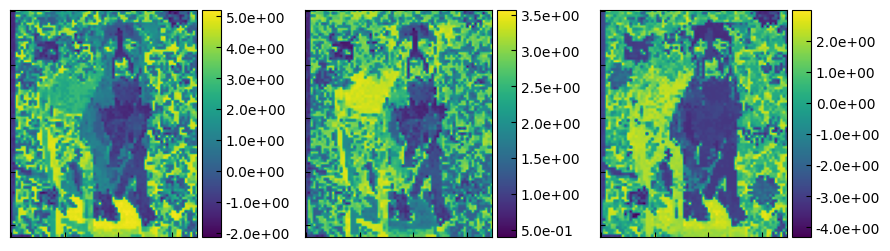

In [22]:
embedding_maps(encode, image)

- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


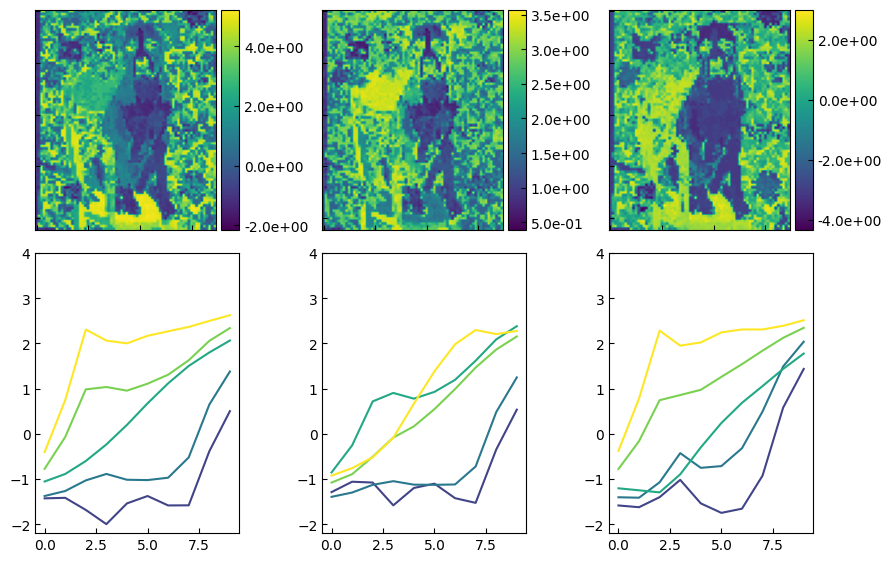

In [23]:
latent_generator(decoder, encode, image, 5, 10, device=device)

## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [24]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [25]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

### Dataloader


In [26]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [27]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:01<00:32,  1.82s/it]

 68%|██████▊   | 13/19 [00:01<00:00,  9.17it/s]

100%|██████████| 19/19 [00:01<00:00,  9.57it/s]

Epoch 0, Train Loss: 1.9070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.17it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 1, Train Loss: 1.9033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 2, Train Loss: 1.8997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 3, Train Loss: 1.8961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 4, Train Loss: 1.8926
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 5, Train Loss: 1.8891
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 6, Train Loss: 1.8856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 7, Train Loss: 1.8822
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 8, Train Loss: 1.8788
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 9, Train Loss: 1.8754
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 10, Train Loss: 1.8720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 11, Train Loss: 1.8685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 12, Train Loss: 1.8651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 13, Train Loss: 1.8617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 14, Train Loss: 1.8582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 15, Train Loss: 1.8547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 16, Train Loss: 1.8511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 17, Train Loss: 1.8474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 121.49it/s]

100%|██████████| 19/19 [00:00<00:00, 123.38it/s]

Epoch 18, Train Loss: 1.8437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 119.50it/s]

Epoch 19, Train Loss: 1.8399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 122.64it/s]

100%|██████████| 19/19 [00:00<00:00, 124.18it/s]

Epoch 20, Train Loss: 1.8359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.68it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 21, Train Loss: 1.8319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 126.69it/s]

Epoch 22, Train Loss: 1.8276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 23, Train Loss: 1.8233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 123.81it/s]

100%|██████████| 19/19 [00:00<00:00, 124.18it/s]

Epoch 24, Train Loss: 1.8187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 125.83it/s]

Epoch 25, Train Loss: 1.8140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 26, Train Loss: 1.8090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 27, Train Loss: 1.8038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 28, Train Loss: 1.7983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 29, Train Loss: 1.7925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 30, Train Loss: 1.7864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 123.38it/s]

Epoch 31, Train Loss: 1.7799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 120.25it/s]

Epoch 32, Train Loss: 1.7730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 33, Train Loss: 1.7657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 34, Train Loss: 1.7578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.22it/s]

100%|██████████| 19/19 [00:00<00:00, 125.00it/s]

Epoch 35, Train Loss: 1.7494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 122.64it/s]

100%|██████████| 19/19 [00:00<00:00, 123.38it/s]

Epoch 36, Train Loss: 1.7404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 125.83it/s]

Epoch 37, Train Loss: 1.7308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 125.00it/s]

100%|██████████| 19/19 [00:00<00:00, 125.00it/s]

Epoch 38, Train Loss: 1.7204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 39, Train Loss: 1.7093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 40, Train Loss: 1.6973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 41, Train Loss: 1.6845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 42, Train Loss: 1.6707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 43, Train Loss: 1.6558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 122.64it/s]

100%|██████████| 19/19 [00:00<00:00, 123.38it/s]

Epoch 44, Train Loss: 1.6399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 45, Train Loss: 1.6230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 46, Train Loss: 1.6049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 47, Train Loss: 1.5856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 48, Train Loss: 1.5652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 49, Train Loss: 1.5437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 50, Train Loss: 1.5210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 51, Train Loss: 1.4974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 52, Train Loss: 1.4727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 53, Train Loss: 1.4471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 54, Train Loss: 1.4208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 134.75it/s]

Epoch 55, Train Loss: 1.3936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 56, Train Loss: 1.3659
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 57, Train Loss: 1.3375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 58, Train Loss: 1.3087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 59, Train Loss: 1.2795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 60, Train Loss: 1.2498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 61, Train Loss: 1.2199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 124.96it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 62, Train Loss: 1.1898
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 63, Train Loss: 1.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 64, Train Loss: 1.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 65, Train Loss: 1.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 66, Train Loss: 1.0681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 67, Train Loss: 1.0377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 68, Train Loss: 1.0074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 69, Train Loss: 0.9772
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 70, Train Loss: 0.9472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 71, Train Loss: 0.9175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 72, Train Loss: 0.8881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 73, Train Loss: 0.8591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 74, Train Loss: 0.8306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 75, Train Loss: 0.8027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 76, Train Loss: 0.7753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 77, Train Loss: 0.7486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 78, Train Loss: 0.7227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 79, Train Loss: 0.6976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 80, Train Loss: 0.6735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 81, Train Loss: 0.6502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 82, Train Loss: 0.6279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 83, Train Loss: 0.6066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 84, Train Loss: 0.5862
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 85, Train Loss: 0.5668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 86, Train Loss: 0.5484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 87, Train Loss: 0.5309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 88, Train Loss: 0.5142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 89, Train Loss: 0.4983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 90, Train Loss: 0.4832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 91, Train Loss: 0.4688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 92, Train Loss: 0.4551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 93, Train Loss: 0.4421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 94, Train Loss: 0.4296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 95, Train Loss: 0.4177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 96, Train Loss: 0.4063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 97, Train Loss: 0.3954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.26it/s]

100%|██████████| 19/19 [00:00<00:00, 131.13it/s]

Epoch 98, Train Loss: 0.3850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 99, Train Loss: 0.3750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 100, Train Loss: 0.3655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.94it/s]

100%|██████████| 19/19 [00:00<00:00, 130.76it/s]

Epoch 101, Train Loss: 0.3563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.78it/s]

100%|██████████| 19/19 [00:00<00:00, 130.99it/s]

Epoch 102, Train Loss: 0.3476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 103, Train Loss: 0.3393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 104, Train Loss: 0.3313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 105, Train Loss: 0.3237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 128.41it/s]

Epoch 106, Train Loss: 0.3164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 107, Train Loss: 0.3094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 108, Train Loss: 0.3028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 109, Train Loss: 0.2965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.22it/s]

100%|██████████| 19/19 [00:00<00:00, 128.81it/s]

Epoch 110, Train Loss: 0.2904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 130.99it/s]

Epoch 111, Train Loss: 0.2847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 112, Train Loss: 0.2792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 113, Train Loss: 0.2739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 114, Train Loss: 0.2689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.39it/s]

100%|██████████| 19/19 [00:00<00:00, 132.91it/s]

Epoch 115, Train Loss: 0.2642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 116, Train Loss: 0.2597
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.12it/s]

100%|██████████| 19/19 [00:00<00:00, 130.50it/s]

Epoch 117, Train Loss: 0.2554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 118, Train Loss: 0.2513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 119, Train Loss: 0.2474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.57it/s]

100%|██████████| 19/19 [00:00<00:00, 131.39it/s]

Epoch 120, Train Loss: 0.2437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 121, Train Loss: 0.2402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.81it/s]

100%|██████████| 19/19 [00:00<00:00, 130.00it/s]

Epoch 122, Train Loss: 0.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 123, Train Loss: 0.2338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.83it/s]

100%|██████████| 19/19 [00:00<00:00, 130.02it/s]

Epoch 124, Train Loss: 0.2308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.91it/s]

100%|██████████| 19/19 [00:00<00:00, 131.09it/s]

Epoch 125, Train Loss: 0.2279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.81it/s]

100%|██████████| 19/19 [00:00<00:00, 131.75it/s]

Epoch 126, Train Loss: 0.2252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 127, Train Loss: 0.2227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.76it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 128, Train Loss: 0.2202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 129, Train Loss: 0.2179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 130, Train Loss: 0.2158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 131, Train Loss: 0.2137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.42it/s]

100%|██████████| 19/19 [00:00<00:00, 132.01it/s]

Epoch 132, Train Loss: 0.2117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.58it/s]

100%|██████████| 19/19 [00:00<00:00, 130.31it/s]

Epoch 133, Train Loss: 0.2099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.97it/s]

100%|██████████| 19/19 [00:00<00:00, 131.87it/s]

Epoch 134, Train Loss: 0.2081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.49it/s]

100%|██████████| 19/19 [00:00<00:00, 132.98it/s]

Epoch 135, Train Loss: 0.2065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 136, Train Loss: 0.2049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 137, Train Loss: 0.2034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 138, Train Loss: 0.2020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 129.29it/s]

Epoch 139, Train Loss: 0.2007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 140, Train Loss: 0.1994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 141, Train Loss: 0.1982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.14it/s]

100%|██████████| 19/19 [00:00<00:00, 131.08it/s]

Epoch 142, Train Loss: 0.1971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.74it/s]

100%|██████████| 19/19 [00:00<00:00, 131.69it/s]

Epoch 143, Train Loss: 0.1960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.54it/s]

100%|██████████| 19/19 [00:00<00:00, 130.98it/s]

Epoch 144, Train Loss: 0.1950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 145, Train Loss: 0.1940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.91it/s]

Epoch 146, Train Loss: 0.1931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.99it/s]

100%|██████████| 19/19 [00:00<00:00, 130.13it/s]

Epoch 147, Train Loss: 0.1923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 148, Train Loss: 0.1915
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 122.68it/s]

100%|██████████| 19/19 [00:00<00:00, 123.40it/s]

Epoch 149, Train Loss: 0.1907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 150, Train Loss: 0.1900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 151, Train Loss: 0.1893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 152, Train Loss: 0.1886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 153, Train Loss: 0.1880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 126.69it/s]

Epoch 154, Train Loss: 0.1874
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 155, Train Loss: 0.1869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 156, Train Loss: 0.1863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.46it/s]

100%|██████████| 19/19 [00:00<00:00, 129.26it/s]

Epoch 157, Train Loss: 0.1858
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 158, Train Loss: 0.1854
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 159, Train Loss: 0.1849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.88it/s]

Epoch 160, Train Loss: 0.1845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 161, Train Loss: 0.1841
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.91it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 162, Train Loss: 0.1837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 163, Train Loss: 0.1833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 164, Train Loss: 0.1829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 165, Train Loss: 0.1826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 127.51it/s]

Epoch 166, Train Loss: 0.1823
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.06it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 167, Train Loss: 0.1820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.24it/s]

100%|██████████| 19/19 [00:00<00:00, 132.51it/s]

Epoch 168, Train Loss: 0.1817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.69it/s]

100%|██████████| 19/19 [00:00<00:00, 130.57it/s]

Epoch 169, Train Loss: 0.1814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 127.55it/s]

Epoch 170, Train Loss: 0.1811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 132.83it/s]

Epoch 171, Train Loss: 0.1808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 126.69it/s]

Epoch 172, Train Loss: 0.1806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 173, Train Loss: 0.1803
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 174, Train Loss: 0.1801
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 175, Train Loss: 0.1798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 176, Train Loss: 0.1796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 177, Train Loss: 0.1794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.81it/s]

100%|██████████| 19/19 [00:00<00:00, 132.08it/s]

Epoch 178, Train Loss: 0.1791
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 179, Train Loss: 0.1789
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 180, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 181, Train Loss: 0.1785
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 182, Train Loss: 0.1783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 183, Train Loss: 0.1781
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 184, Train Loss: 0.1779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 185, Train Loss: 0.1777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 125.04it/s]

100%|██████████| 19/19 [00:00<00:00, 125.85it/s]

Epoch 186, Train Loss: 0.1776
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 187, Train Loss: 0.1774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 188, Train Loss: 0.1772
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.22it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 189, Train Loss: 0.1770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 190, Train Loss: 0.1768
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 191, Train Loss: 0.1767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 192, Train Loss: 0.1765
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 193, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 194, Train Loss: 0.1761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 195, Train Loss: 0.1760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 196, Train Loss: 0.1758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 197, Train Loss: 0.1756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 198, Train Loss: 0.1755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.13it/s]

100%|██████████| 19/19 [00:00<00:00, 131.99it/s]

Epoch 199, Train Loss: 0.1753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 200, Train Loss: 0.1751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.87it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 201, Train Loss: 0.1750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 202, Train Loss: 0.1748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 203, Train Loss: 0.1746
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 204, Train Loss: 0.1745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 205, Train Loss: 0.1743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 206, Train Loss: 0.1741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 207, Train Loss: 0.1740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 208, Train Loss: 0.1738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.13it/s]

Epoch 209, Train Loss: 0.1736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 210, Train Loss: 0.1735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 211, Train Loss: 0.1733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 212, Train Loss: 0.1731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 213, Train Loss: 0.1730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 214, Train Loss: 0.1728
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 215, Train Loss: 0.1726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.96it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 216, Train Loss: 0.1725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 217, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 218, Train Loss: 0.1721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 219, Train Loss: 0.1720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 220, Train Loss: 0.1718
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 221, Train Loss: 0.1716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 222, Train Loss: 0.1714
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 223, Train Loss: 0.1713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 224, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.13it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 225, Train Loss: 0.1709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 226, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.77it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 227, Train Loss: 0.1706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.87it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 228, Train Loss: 0.1704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 229, Train Loss: 0.1702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 230, Train Loss: 0.1700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.80it/s]

Epoch 231, Train Loss: 0.1698
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.05it/s]

100%|██████████| 19/19 [00:00<00:00, 132.50it/s]

Epoch 232, Train Loss: 0.1697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 233, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 234, Train Loss: 0.1693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 235, Train Loss: 0.1691
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.82it/s]

100%|██████████| 19/19 [00:00<00:00, 131.72it/s]

Epoch 236, Train Loss: 0.1689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.86it/s]

100%|██████████| 19/19 [00:00<00:00, 131.79it/s]

Epoch 237, Train Loss: 0.1687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 238, Train Loss: 0.1685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 239, Train Loss: 0.1683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 240, Train Loss: 0.1681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 127.55it/s]

Epoch 241, Train Loss: 0.1679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 242, Train Loss: 0.1677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.50it/s]

100%|██████████| 19/19 [00:00<00:00, 127.55it/s]

Epoch 243, Train Loss: 0.1675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 244, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 245, Train Loss: 0.1671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.10it/s]

100%|██████████| 19/19 [00:00<00:00, 130.33it/s]

Epoch 246, Train Loss: 0.1669
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 129.29it/s]

Epoch 247, Train Loss: 0.1667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 248, Train Loss: 0.1665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 249, Train Loss: 0.1663
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 250, Train Loss: 0.1660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 251, Train Loss: 0.1658
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 252, Train Loss: 0.1656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 253, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 254, Train Loss: 0.1652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 255, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 256, Train Loss: 0.1647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 257, Train Loss: 0.1645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 258, Train Loss: 0.1642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 259, Train Loss: 0.1640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.87it/s]

100%|██████████| 19/19 [00:00<00:00, 132.53it/s]

Epoch 260, Train Loss: 0.1637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.70it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 261, Train Loss: 0.1635
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.24it/s]

100%|██████████| 19/19 [00:00<00:00, 130.22it/s]

Epoch 262, Train Loss: 0.1633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.13it/s]

100%|██████████| 19/19 [00:00<00:00, 131.28it/s]

Epoch 263, Train Loss: 0.1630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.68it/s]

100%|██████████| 19/19 [00:00<00:00, 126.61it/s]

Epoch 264, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.70it/s]

100%|██████████| 19/19 [00:00<00:00, 129.07it/s]

Epoch 265, Train Loss: 0.1625
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.80it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 266, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.82it/s]

100%|██████████| 19/19 [00:00<00:00, 130.67it/s]

Epoch 267, Train Loss: 0.1620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 268, Train Loss: 0.1617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 269, Train Loss: 0.1615
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.76it/s]

100%|██████████| 19/19 [00:00<00:00, 129.29it/s]

Epoch 270, Train Loss: 0.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 271, Train Loss: 0.1609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 272, Train Loss: 0.1607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.08it/s]

Epoch 273, Train Loss: 0.1604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.26it/s]

100%|██████████| 19/19 [00:00<00:00, 130.27it/s]

Epoch 274, Train Loss: 0.1601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.90it/s]

Epoch 275, Train Loss: 0.1599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 276, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 277, Train Loss: 0.1593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 278, Train Loss: 0.1590
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 279, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 280, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.21it/s]

100%|██████████| 19/19 [00:00<00:00, 130.21it/s]

Epoch 281, Train Loss: 0.1582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.68it/s]

100%|██████████| 19/19 [00:00<00:00, 130.75it/s]

Epoch 282, Train Loss: 0.1579
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.86it/s]

Epoch 283, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 284, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 128.35it/s]

Epoch 285, Train Loss: 0.1571
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.83it/s]

Epoch 286, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 287, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.66it/s]

100%|██████████| 19/19 [00:00<00:00, 129.22it/s]

Epoch 288, Train Loss: 0.1563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 128.41it/s]

Epoch 289, Train Loss: 0.1560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 290, Train Loss: 0.1557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 291, Train Loss: 0.1554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.09it/s]

100%|██████████| 19/19 [00:00<00:00, 129.51it/s]

Epoch 292, Train Loss: 0.1552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.19it/s]

100%|██████████| 19/19 [00:00<00:00, 133.22it/s]

Epoch 293, Train Loss: 0.1549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 294, Train Loss: 0.1546
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.90it/s]

100%|██████████| 19/19 [00:00<00:00, 129.10it/s]

Epoch 295, Train Loss: 0.1543
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 296, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.44it/s]

Epoch 297, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 298, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 299, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 300, Train Loss: 0.1529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.61it/s]

100%|██████████| 19/19 [00:00<00:00, 129.87it/s]

Epoch 301, Train Loss: 0.1527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 302, Train Loss: 0.1524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 131.90it/s]

Epoch 303, Train Loss: 0.1521
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.97it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 304, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.93it/s]

100%|██████████| 19/19 [00:00<00:00, 131.65it/s]

Epoch 305, Train Loss: 0.1516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.81it/s]

100%|██████████| 19/19 [00:00<00:00, 131.60it/s]

Epoch 306, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.62it/s]

100%|██████████| 19/19 [00:00<00:00, 129.01it/s]

Epoch 307, Train Loss: 0.1510
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 308, Train Loss: 0.1507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.95it/s]

100%|██████████| 19/19 [00:00<00:00, 128.87it/s]

Epoch 309, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 310, Train Loss: 0.1502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 311, Train Loss: 0.1499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.82it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 312, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.23it/s]

100%|██████████| 19/19 [00:00<00:00, 132.79it/s]

Epoch 313, Train Loss: 0.1494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 314, Train Loss: 0.1491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 315, Train Loss: 0.1488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.03it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 316, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.32it/s]

100%|██████████| 19/19 [00:00<00:00, 132.85it/s]

Epoch 317, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.83it/s]

Epoch 318, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 319, Train Loss: 0.1478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 320, Train Loss: 0.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 321, Train Loss: 0.1473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 322, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 323, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 324, Train Loss: 0.1465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 325, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 326, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 327, Train Loss: 0.1457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.77it/s]

100%|██████████| 19/19 [00:00<00:00, 133.91it/s]

Epoch 328, Train Loss: 0.1455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.10it/s]

100%|██████████| 19/19 [00:00<00:00, 128.39it/s]

Epoch 329, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 131.20it/s]

Epoch 330, Train Loss: 0.1450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.16it/s]

100%|██████████| 19/19 [00:00<00:00, 132.74it/s]

Epoch 331, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.48it/s]

100%|██████████| 19/19 [00:00<00:00, 132.75it/s]

Epoch 332, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 128.65it/s]

Epoch 333, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.81it/s]

100%|██████████| 19/19 [00:00<00:00, 132.20it/s]

Epoch 334, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 130.15it/s]

Epoch 335, Train Loss: 0.1438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.28it/s]

100%|██████████| 19/19 [00:00<00:00, 131.18it/s]

Epoch 336, Train Loss: 0.1435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.22it/s]

100%|██████████| 19/19 [00:00<00:00, 131.85it/s]

Epoch 337, Train Loss: 0.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.77it/s]

100%|██████████| 19/19 [00:00<00:00, 132.26it/s]

Epoch 338, Train Loss: 0.1431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 339, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 340, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 341, Train Loss: 0.1424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 342, Train Loss: 0.1422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 343, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.79it/s]

100%|██████████| 19/19 [00:00<00:00, 132.47it/s]

Epoch 344, Train Loss: 0.1417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.88it/s]

100%|██████████| 19/19 [00:00<00:00, 133.99it/s]

Epoch 345, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 346, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.78it/s]

Epoch 347, Train Loss: 0.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 348, Train Loss: 0.1409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.29it/s]

100%|██████████| 19/19 [00:00<00:00, 133.35it/s]

Epoch 349, Train Loss: 0.1406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 350, Train Loss: 0.1404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 351, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 352, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 353, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 354, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.09it/s]

100%|██████████| 19/19 [00:00<00:00, 131.21it/s]

Epoch 355, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 356, Train Loss: 0.1392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.06it/s]

100%|██████████| 19/19 [00:00<00:00, 131.75it/s]

Epoch 357, Train Loss: 0.1390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 358, Train Loss: 0.1388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 132.12it/s]

Epoch 359, Train Loss: 0.1386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.86it/s]

100%|██████████| 19/19 [00:00<00:00, 131.60it/s]

Epoch 360, Train Loss: 0.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.05it/s]

100%|██████████| 19/19 [00:00<00:00, 131.02it/s]

Epoch 361, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 362, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 363, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 120.25it/s]

Epoch 364, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 365, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 366, Train Loss: 0.1372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 367, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 368, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 369, Train Loss: 0.1367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 370, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 371, Train Loss: 0.1363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 372, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 373, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 374, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 375, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 376, Train Loss: 0.1354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 377, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 378, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 379, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.81it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 380, Train Loss: 0.1346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 381, Train Loss: 0.1344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 131.93it/s]

Epoch 382, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.10it/s]

Epoch 383, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 384, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.59it/s]

100%|██████████| 19/19 [00:00<00:00, 132.85it/s]

Epoch 385, Train Loss: 0.1337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 386, Train Loss: 0.1335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 387, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 388, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 389, Train Loss: 0.1330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 390, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 391, Train Loss: 0.1326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 134.72it/s]

Epoch 392, Train Loss: 0.1324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 393, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 394, Train Loss: 0.1321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.43it/s]

100%|██████████| 19/19 [00:00<00:00, 129.50it/s]

Epoch 395, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.44it/s]

100%|██████████| 19/19 [00:00<00:00, 132.02it/s]

Epoch 396, Train Loss: 0.1317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 397, Train Loss: 0.1315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 119.52it/s]

Epoch 398, Train Loss: 0.1313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.21it/s]

100%|██████████| 19/19 [00:00<00:00, 125.85it/s]

Epoch 399, Train Loss: 0.1312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.85it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 400, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 401, Train Loss: 0.1308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 402, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 403, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.80it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 404, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 405, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 406, Train Loss: 0.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 407, Train Loss: 0.1297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 408, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.61it/s]

100%|██████████| 19/19 [00:00<00:00, 128.49it/s]

Epoch 409, Train Loss: 0.1293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 410, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 411, Train Loss: 0.1290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 412, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 133.12it/s]

Epoch 413, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 414, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 415, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.29it/s]

100%|██████████| 19/19 [00:00<00:00, 133.56it/s]

Epoch 416, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.76it/s]

100%|██████████| 19/19 [00:00<00:00, 130.80it/s]

Epoch 417, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 418, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.79it/s]

100%|██████████| 19/19 [00:00<00:00, 131.55it/s]

Epoch 419, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 420, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 128.26it/s]

Epoch 421, Train Loss: 0.1271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 422, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.98it/s]

100%|██████████| 19/19 [00:00<00:00, 130.12it/s]

Epoch 423, Train Loss: 0.1267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.10it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 424, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.49it/s]

Epoch 425, Train Loss: 0.1263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.74it/s]

Epoch 426, Train Loss: 0.1261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 427, Train Loss: 0.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.19it/s]

100%|██████████| 19/19 [00:00<00:00, 130.93it/s]

Epoch 428, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 429, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.33it/s]

Epoch 430, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 126.25it/s]

100%|██████████| 19/19 [00:00<00:00, 126.69it/s]

Epoch 431, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 432, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 433, Train Loss: 0.1248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.22it/s]

100%|██████████| 19/19 [00:00<00:00, 131.79it/s]

Epoch 434, Train Loss: 0.1246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.80it/s]

100%|██████████| 19/19 [00:00<00:00, 132.48it/s]

Epoch 435, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 436, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 437, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.10it/s]

100%|██████████| 19/19 [00:00<00:00, 131.05it/s]

Epoch 438, Train Loss: 0.1239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 439, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.39it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 440, Train Loss: 0.1235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.41it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 441, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 442, Train Loss: 0.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 443, Train Loss: 0.1229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 444, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 445, Train Loss: 0.1225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 446, Train Loss: 0.1223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 447, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 448, Train Loss: 0.1220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 449, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 450, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 451, Train Loss: 0.1214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 452, Train Loss: 0.1212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 453, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 454, Train Loss: 0.1208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 455, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 456, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.31it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 457, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 458, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.81it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 459, Train Loss: 0.1199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 460, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 461, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 56.44it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 55.38it/s]

100%|██████████| 19/19 [00:00<00:00, 67.85it/s]

Epoch 462, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 463, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.18it/s]

100%|██████████| 19/19 [00:00<00:00, 131.84it/s]

Epoch 464, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 465, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.45it/s]

100%|██████████| 19/19 [00:00<00:00, 132.03it/s]

Epoch 466, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 467, Train Loss: 0.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 468, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 469, Train Loss: 0.1179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 470, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 471, Train Loss: 0.1175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 472, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 473, Train Loss: 0.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 474, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.40it/s]

Epoch 475, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.17it/s]

Epoch 476, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.97it/s]

100%|██████████| 19/19 [00:00<00:00, 127.49it/s]

Epoch 477, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.68it/s]

100%|██████████| 19/19 [00:00<00:00, 129.22it/s]

Epoch 478, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.74it/s]

100%|██████████| 19/19 [00:00<00:00, 129.27it/s]

Epoch 479, Train Loss: 0.1160
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.86it/s]

100%|██████████| 19/19 [00:00<00:00, 129.16it/s]

Epoch 480, Train Loss: 0.1158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.48it/s]

Epoch 481, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.80it/s]

100%|██████████| 19/19 [00:00<00:00, 129.38it/s]

Epoch 482, Train Loss: 0.1154
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 127.58it/s]

Epoch 483, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.11it/s]

100%|██████████| 19/19 [00:00<00:00, 127.29it/s]

Epoch 484, Train Loss: 0.1150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.68it/s]

100%|██████████| 19/19 [00:00<00:00, 129.29it/s]

Epoch 485, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.39it/s]

100%|██████████| 19/19 [00:00<00:00, 128.16it/s]

Epoch 486, Train Loss: 0.1146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.85it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 487, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.46it/s]

100%|██████████| 19/19 [00:00<00:00, 128.02it/s]

Epoch 488, Train Loss: 0.1142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 128.41it/s]

Epoch 489, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.14it/s]

100%|██████████| 19/19 [00:00<00:00, 129.47it/s]

Epoch 490, Train Loss: 0.1138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.41it/s]

Epoch 491, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 492, Train Loss: 0.1134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 125.83it/s]

Epoch 493, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 494, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 495, Train Loss: 0.1128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 496, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 497, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 498, Train Loss: 0.1122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 499, Train Loss: 0.1120
.............................


### Validation


In [28]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

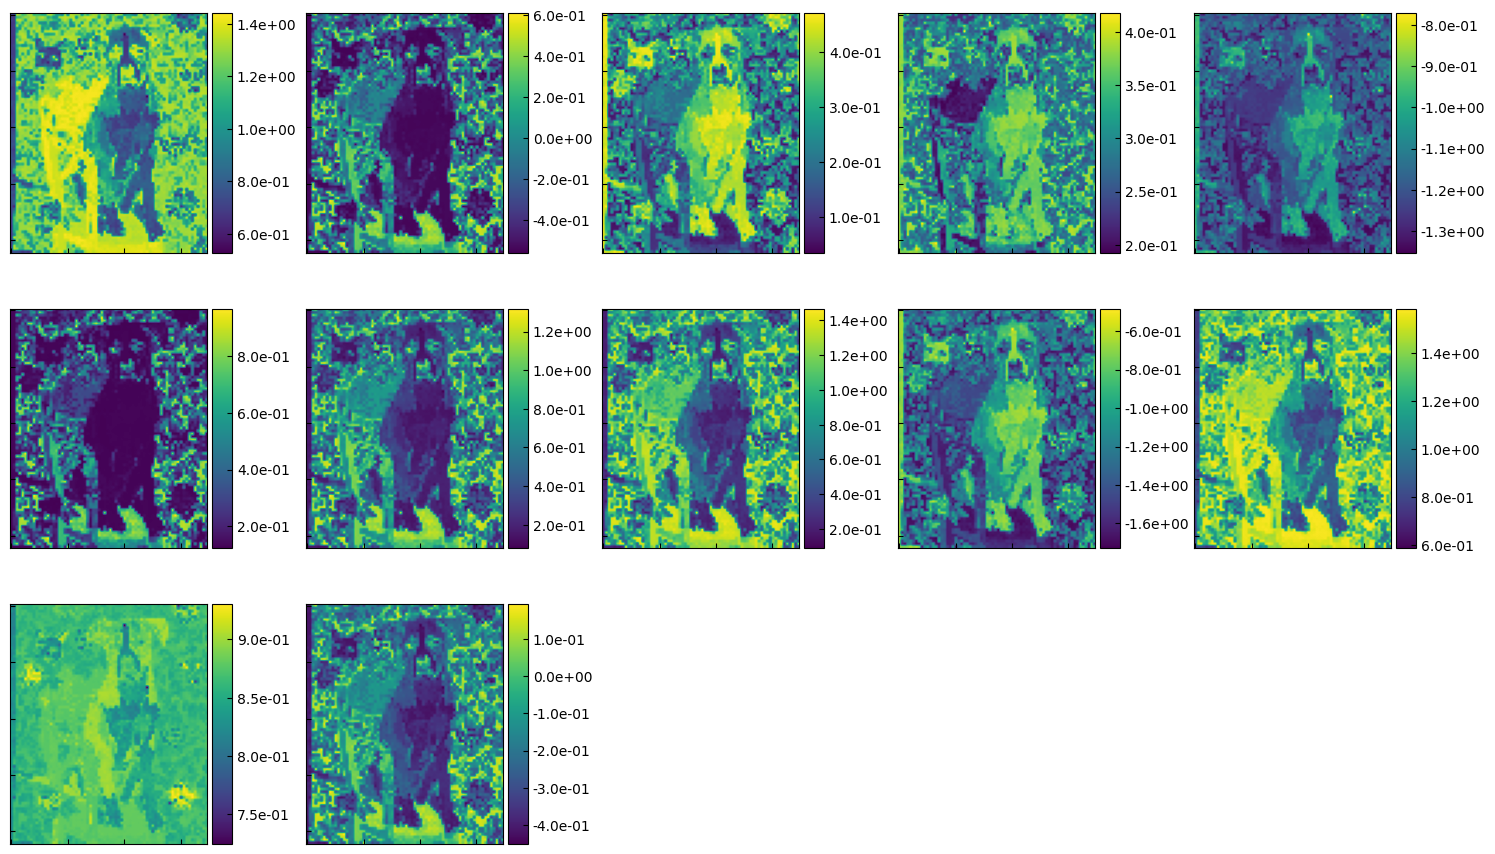

In [29]:
embedding_maps(encode, image)

- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [30]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [31]:
model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [32]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [33]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 127.76it/s]

Epoch 0, Train Loss: 2.1234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 121.46it/s]

100%|██████████| 19/19 [00:00<00:00, 122.58it/s]

Epoch 1, Train Loss: 2.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.03it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 2, Train Loss: 2.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 3, Train Loss: 2.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.83it/s]

100%|██████████| 19/19 [00:00<00:00, 131.61it/s]

Epoch 4, Train Loss: 2.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.99it/s]

100%|██████████| 19/19 [00:00<00:00, 131.84it/s]

Epoch 5, Train Loss: 2.0984
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 6, Train Loss: 2.0933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 7, Train Loss: 2.0882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.42it/s]

100%|██████████| 19/19 [00:00<00:00, 132.93it/s]

Epoch 8, Train Loss: 2.0830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 9, Train Loss: 2.0777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.67it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 10, Train Loss: 2.0724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 11, Train Loss: 2.0670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.44it/s]

100%|██████████| 19/19 [00:00<00:00, 131.41it/s]

Epoch 12, Train Loss: 2.0616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 13, Train Loss: 2.0561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 14, Train Loss: 2.0506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 15, Train Loss: 2.0449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 16, Train Loss: 2.0392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.10it/s]

100%|██████████| 19/19 [00:00<00:00, 131.05it/s]

Epoch 17, Train Loss: 2.0334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 18, Train Loss: 2.0275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 19, Train Loss: 2.0216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 20, Train Loss: 2.0155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 21, Train Loss: 2.0094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 22, Train Loss: 2.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 23, Train Loss: 1.9967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 24, Train Loss: 1.9903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 25, Train Loss: 1.9837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.86it/s]

100%|██████████| 19/19 [00:00<00:00, 130.88it/s]

Epoch 26, Train Loss: 1.9770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.51it/s]

100%|██████████| 19/19 [00:00<00:00, 133.00it/s]

Epoch 27, Train Loss: 1.9702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 28, Train Loss: 1.9632
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.52it/s]

100%|██████████| 19/19 [00:00<00:00, 131.36it/s]

Epoch 29, Train Loss: 1.9562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.51it/s]

100%|██████████| 19/19 [00:00<00:00, 131.50it/s]

Epoch 30, Train Loss: 1.9490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.81it/s]

Epoch 31, Train Loss: 1.9417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.99it/s]

100%|██████████| 19/19 [00:00<00:00, 130.97it/s]

Epoch 32, Train Loss: 1.9342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 33, Train Loss: 1.9266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 34, Train Loss: 1.9189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 35, Train Loss: 1.9111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 36, Train Loss: 1.9031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.13it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 37, Train Loss: 1.8949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.44it/s]

100%|██████████| 19/19 [00:00<00:00, 128.44it/s]

Epoch 38, Train Loss: 1.8867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.17it/s]

100%|██████████| 19/19 [00:00<00:00, 133.27it/s]

Epoch 39, Train Loss: 1.8782
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 40, Train Loss: 1.8697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 41, Train Loss: 1.8610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 42, Train Loss: 1.8522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 43, Train Loss: 1.8433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 44, Train Loss: 1.8342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.59it/s]

100%|██████████| 19/19 [00:00<00:00, 132.32it/s]

Epoch 45, Train Loss: 1.8250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.41it/s]

100%|██████████| 19/19 [00:00<00:00, 123.38it/s]

Epoch 46, Train Loss: 1.8156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.85it/s]

100%|██████████| 19/19 [00:00<00:00, 129.34it/s]

Epoch 47, Train Loss: 1.8062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.33it/s]

100%|██████████| 19/19 [00:00<00:00, 133.66it/s]

Epoch 48, Train Loss: 1.7966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 49, Train Loss: 1.7869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.70it/s]

100%|██████████| 19/19 [00:00<00:00, 133.13it/s]

Epoch 50, Train Loss: 1.7770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 51, Train Loss: 1.7671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 52, Train Loss: 1.7570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 53, Train Loss: 1.7468
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 54, Train Loss: 1.7365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 55, Train Loss: 1.7260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 56, Train Loss: 1.7155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.32it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 57, Train Loss: 1.7049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 58, Train Loss: 1.6941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.19it/s]

100%|██████████| 19/19 [00:00<00:00, 132.77it/s]

Epoch 59, Train Loss: 1.6833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 60, Train Loss: 1.6723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.36it/s]

100%|██████████| 19/19 [00:00<00:00, 133.01it/s]

Epoch 61, Train Loss: 1.6613
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.73it/s]

100%|██████████| 19/19 [00:00<00:00, 132.42it/s]

Epoch 62, Train Loss: 1.6503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 63, Train Loss: 1.6391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.72it/s]

100%|██████████| 19/19 [00:00<00:00, 132.94it/s]

Epoch 64, Train Loss: 1.6279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.72it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 65, Train Loss: 1.6167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.83it/s]

100%|██████████| 19/19 [00:00<00:00, 130.07it/s]

Epoch 66, Train Loss: 1.6054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.77it/s]

100%|██████████| 19/19 [00:00<00:00, 130.98it/s]

Epoch 67, Train Loss: 1.5942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 68, Train Loss: 1.5829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 69, Train Loss: 1.5717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 70, Train Loss: 1.5605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 71, Train Loss: 1.5493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 72, Train Loss: 1.5382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.84it/s]

Epoch 73, Train Loss: 1.5272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.54it/s]

100%|██████████| 19/19 [00:00<00:00, 129.82it/s]

Epoch 74, Train Loss: 1.5162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.48it/s]

100%|██████████| 19/19 [00:00<00:00, 131.52it/s]

Epoch 75, Train Loss: 1.5052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.13it/s]

100%|██████████| 19/19 [00:00<00:00, 132.71it/s]

Epoch 76, Train Loss: 1.4943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.67it/s]

100%|██████████| 19/19 [00:00<00:00, 132.20it/s]

Epoch 77, Train Loss: 1.4835
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.32it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 78, Train Loss: 1.4727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.43it/s]

100%|██████████| 19/19 [00:00<00:00, 130.57it/s]

Epoch 79, Train Loss: 1.4620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.35it/s]

100%|██████████| 19/19 [00:00<00:00, 132.88it/s]

Epoch 80, Train Loss: 1.4512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.85it/s]

Epoch 81, Train Loss: 1.4405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 82, Train Loss: 1.4298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 83, Train Loss: 1.4191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.20it/s]

100%|██████████| 19/19 [00:00<00:00, 133.28it/s]

Epoch 84, Train Loss: 1.4084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.90it/s]

100%|██████████| 19/19 [00:00<00:00, 130.07it/s]

Epoch 85, Train Loss: 1.3976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.26it/s]

Epoch 86, Train Loss: 1.3868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.10it/s]

100%|██████████| 19/19 [00:00<00:00, 128.59it/s]

Epoch 87, Train Loss: 1.3759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.57it/s]

100%|██████████| 19/19 [00:00<00:00, 130.70it/s]

Epoch 88, Train Loss: 1.3650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 124.82it/s]

100%|██████████| 19/19 [00:00<00:00, 127.27it/s]

Epoch 89, Train Loss: 1.3539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.05it/s]

100%|██████████| 19/19 [00:00<00:00, 131.74it/s]

Epoch 90, Train Loss: 1.3428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.01it/s]

100%|██████████| 19/19 [00:00<00:00, 128.31it/s]

Epoch 91, Train Loss: 1.3315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.42it/s]

100%|██████████| 19/19 [00:00<00:00, 132.20it/s]

Epoch 92, Train Loss: 1.3201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 93, Train Loss: 1.3086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 94, Train Loss: 1.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 95, Train Loss: 1.2851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 96, Train Loss: 1.2731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 97, Train Loss: 1.2610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 98, Train Loss: 1.2487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.13it/s]

Epoch 99, Train Loss: 1.2363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 100, Train Loss: 1.2237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.68it/s]

100%|██████████| 19/19 [00:00<00:00, 130.18it/s]

Epoch 101, Train Loss: 1.2110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.90it/s]

100%|██████████| 19/19 [00:00<00:00, 130.96it/s]

Epoch 102, Train Loss: 1.1981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.94it/s]

100%|██████████| 19/19 [00:00<00:00, 131.11it/s]

Epoch 103, Train Loss: 1.1851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.83it/s]

100%|██████████| 19/19 [00:00<00:00, 132.09it/s]

Epoch 104, Train Loss: 1.1720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.94it/s]

100%|██████████| 19/19 [00:00<00:00, 131.43it/s]

Epoch 105, Train Loss: 1.1587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 106, Train Loss: 1.1453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 107, Train Loss: 1.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.76it/s]

100%|██████████| 19/19 [00:00<00:00, 133.00it/s]

Epoch 108, Train Loss: 1.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 109, Train Loss: 1.1046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 110, Train Loss: 1.0909
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 111, Train Loss: 1.0771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.47it/s]

100%|██████████| 19/19 [00:00<00:00, 130.23it/s]

Epoch 112, Train Loss: 1.0633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.79it/s]

100%|██████████| 19/19 [00:00<00:00, 132.28it/s]

Epoch 113, Train Loss: 1.0495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 114, Train Loss: 1.0357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 115, Train Loss: 1.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 116, Train Loss: 1.0080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 117, Train Loss: 0.9942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 118, Train Loss: 0.9805
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.07it/s]

100%|██████████| 19/19 [00:00<00:00, 132.48it/s]

Epoch 119, Train Loss: 0.9668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.98it/s]

100%|██████████| 19/19 [00:00<00:00, 130.24it/s]

Epoch 120, Train Loss: 0.9531
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 121, Train Loss: 0.9396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 122, Train Loss: 0.9261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.40it/s]

100%|██████████| 19/19 [00:00<00:00, 131.99it/s]

Epoch 123, Train Loss: 0.9127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.59it/s]

Epoch 124, Train Loss: 0.8995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.98it/s]

100%|██████████| 19/19 [00:00<00:00, 131.69it/s]

Epoch 125, Train Loss: 0.8863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.58it/s]

100%|██████████| 19/19 [00:00<00:00, 132.12it/s]

Epoch 126, Train Loss: 0.8733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.78it/s]

Epoch 127, Train Loss: 0.8603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 128, Train Loss: 0.8475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.33it/s]

Epoch 129, Train Loss: 0.8348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 130, Train Loss: 0.8222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.06it/s]

Epoch 131, Train Loss: 0.8097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.15it/s]

100%|██████████| 19/19 [00:00<00:00, 130.91it/s]

Epoch 132, Train Loss: 0.7973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 133, Train Loss: 0.7851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.94it/s]

100%|██████████| 19/19 [00:00<00:00, 129.32it/s]

Epoch 134, Train Loss: 0.7729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 135, Train Loss: 0.7609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 136, Train Loss: 0.7489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.92it/s]

100%|██████████| 19/19 [00:00<00:00, 129.49it/s]

Epoch 137, Train Loss: 0.7371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.54it/s]

100%|██████████| 19/19 [00:00<00:00, 128.87it/s]

Epoch 138, Train Loss: 0.7254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 139, Train Loss: 0.7137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.66it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 140, Train Loss: 0.7022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 130.06it/s]

Epoch 141, Train Loss: 0.6908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 142, Train Loss: 0.6794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 143, Train Loss: 0.6682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 144, Train Loss: 0.6570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 132.83it/s]

Epoch 145, Train Loss: 0.6460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 146, Train Loss: 0.6351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 147, Train Loss: 0.6243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 148, Train Loss: 0.6136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 149, Train Loss: 0.6030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 150, Train Loss: 0.5925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 151, Train Loss: 0.5822
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 152, Train Loss: 0.5720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.46it/s]

100%|██████████| 19/19 [00:00<00:00, 131.15it/s]

Epoch 153, Train Loss: 0.5619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.57it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 154, Train Loss: 0.5520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.53it/s]

100%|██████████| 19/19 [00:00<00:00, 132.08it/s]

Epoch 155, Train Loss: 0.5422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 156, Train Loss: 0.5326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 157, Train Loss: 0.5231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 158, Train Loss: 0.5138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 159, Train Loss: 0.5046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.64it/s]

100%|██████████| 19/19 [00:00<00:00, 130.85it/s]

Epoch 160, Train Loss: 0.4956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.63it/s]

100%|██████████| 19/19 [00:00<00:00, 133.84it/s]

Epoch 161, Train Loss: 0.4867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.56it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 162, Train Loss: 0.4780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.98it/s]

Epoch 163, Train Loss: 0.4695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 164, Train Loss: 0.4611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 165, Train Loss: 0.4529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.74it/s]

100%|██████████| 19/19 [00:00<00:00, 132.96it/s]

Epoch 166, Train Loss: 0.4448
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.27it/s]

100%|██████████| 19/19 [00:00<00:00, 131.90it/s]

Epoch 167, Train Loss: 0.4369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.10it/s]

100%|██████████| 19/19 [00:00<00:00, 131.52it/s]

Epoch 168, Train Loss: 0.4292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.26it/s]

100%|██████████| 19/19 [00:00<00:00, 130.60it/s]

Epoch 169, Train Loss: 0.4217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.55it/s]

100%|██████████| 19/19 [00:00<00:00, 132.82it/s]

Epoch 170, Train Loss: 0.4143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.16it/s]

100%|██████████| 19/19 [00:00<00:00, 132.01it/s]

Epoch 171, Train Loss: 0.4071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 172, Train Loss: 0.4000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.83it/s]

Epoch 173, Train Loss: 0.3931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 174, Train Loss: 0.3864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.87it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 175, Train Loss: 0.3798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.57it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 176, Train Loss: 0.3734
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 177, Train Loss: 0.3672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 178, Train Loss: 0.3611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 179, Train Loss: 0.3552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 180, Train Loss: 0.3494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.51it/s]

100%|██████████| 19/19 [00:00<00:00, 132.07it/s]

Epoch 181, Train Loss: 0.3438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.98it/s]

100%|██████████| 19/19 [00:00<00:00, 129.18it/s]

Epoch 182, Train Loss: 0.3383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 183, Train Loss: 0.3330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 184, Train Loss: 0.3279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 185, Train Loss: 0.3229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.76it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 186, Train Loss: 0.3180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.52it/s]

100%|██████████| 19/19 [00:00<00:00, 132.10it/s]

Epoch 187, Train Loss: 0.3133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.90it/s]

Epoch 188, Train Loss: 0.3088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.66it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 189, Train Loss: 0.3043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 190, Train Loss: 0.3001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 191, Train Loss: 0.2959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 192, Train Loss: 0.2919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.82it/s]

100%|██████████| 19/19 [00:00<00:00, 132.18it/s]

Epoch 193, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 194, Train Loss: 0.2842
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.75it/s]

100%|██████████| 19/19 [00:00<00:00, 131.26it/s]

Epoch 195, Train Loss: 0.2806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.49it/s]

100%|██████████| 19/19 [00:00<00:00, 130.24it/s]

Epoch 196, Train Loss: 0.2771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.91it/s]

100%|██████████| 19/19 [00:00<00:00, 132.54it/s]

Epoch 197, Train Loss: 0.2737
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.82it/s]

100%|██████████| 19/19 [00:00<00:00, 132.31it/s]

Epoch 198, Train Loss: 0.2704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.71it/s]

100%|██████████| 19/19 [00:00<00:00, 130.77it/s]

Epoch 199, Train Loss: 0.2672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.53it/s]

100%|██████████| 19/19 [00:00<00:00, 132.98it/s]

Epoch 200, Train Loss: 0.2642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.21it/s]

100%|██████████| 19/19 [00:00<00:00, 132.57it/s]

Epoch 201, Train Loss: 0.2612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 202, Train Loss: 0.2584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 203, Train Loss: 0.2556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 204, Train Loss: 0.2530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.89it/s]

Epoch 205, Train Loss: 0.2505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.02it/s]

100%|██████████| 19/19 [00:00<00:00, 133.37it/s]

Epoch 206, Train Loss: 0.2480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.98it/s]

100%|██████████| 19/19 [00:00<00:00, 128.37it/s]

Epoch 207, Train Loss: 0.2456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.02it/s]

100%|██████████| 19/19 [00:00<00:00, 134.10it/s]

Epoch 208, Train Loss: 0.2434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 128.35it/s]

Epoch 209, Train Loss: 0.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.71it/s]

100%|██████████| 19/19 [00:00<00:00, 133.14it/s]

Epoch 210, Train Loss: 0.2391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.15it/s]

100%|██████████| 19/19 [00:00<00:00, 132.73it/s]

Epoch 211, Train Loss: 0.2371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 212, Train Loss: 0.2351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.78it/s]

Epoch 213, Train Loss: 0.2332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.88it/s]

100%|██████████| 19/19 [00:00<00:00, 134.72it/s]

Epoch 214, Train Loss: 0.2314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.91it/s]

100%|██████████| 19/19 [00:00<00:00, 130.07it/s]

Epoch 215, Train Loss: 0.2297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.87it/s]

100%|██████████| 19/19 [00:00<00:00, 131.05it/s]

Epoch 216, Train Loss: 0.2280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 217, Train Loss: 0.2264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 218, Train Loss: 0.2249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 219, Train Loss: 0.2234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.29it/s]

100%|██████████| 19/19 [00:00<00:00, 133.56it/s]

Epoch 220, Train Loss: 0.2220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.41it/s]

100%|██████████| 19/19 [00:00<00:00, 132.93it/s]

Epoch 221, Train Loss: 0.2206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.04it/s]

100%|██████████| 19/19 [00:00<00:00, 133.14it/s]

Epoch 222, Train Loss: 0.2193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.79it/s]

Epoch 223, Train Loss: 0.2181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.56it/s]

100%|██████████| 19/19 [00:00<00:00, 130.66it/s]

Epoch 224, Train Loss: 0.2168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 131.00it/s]

Epoch 225, Train Loss: 0.2157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 226, Train Loss: 0.2146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 227, Train Loss: 0.2135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 228, Train Loss: 0.2124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 229, Train Loss: 0.2114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 230, Train Loss: 0.2104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 231, Train Loss: 0.2095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 232, Train Loss: 0.2086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.97it/s]

100%|██████████| 19/19 [00:00<00:00, 130.22it/s]

Epoch 233, Train Loss: 0.2077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 234, Train Loss: 0.2069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.69it/s]

100%|██████████| 19/19 [00:00<00:00, 131.48it/s]

Epoch 235, Train Loss: 0.2061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 236, Train Loss: 0.2053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.90it/s]

100%|██████████| 19/19 [00:00<00:00, 131.08it/s]

Epoch 237, Train Loss: 0.2045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.24it/s]

100%|██████████| 19/19 [00:00<00:00, 131.16it/s]

Epoch 238, Train Loss: 0.2038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.22it/s]

Epoch 239, Train Loss: 0.2030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 240, Train Loss: 0.2023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 241, Train Loss: 0.2016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.27it/s]

100%|██████████| 19/19 [00:00<00:00, 132.60it/s]

Epoch 242, Train Loss: 0.2010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.04it/s]

100%|██████████| 19/19 [00:00<00:00, 129.40it/s]

Epoch 243, Train Loss: 0.2003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.93it/s]

100%|██████████| 19/19 [00:00<00:00, 130.04it/s]

Epoch 244, Train Loss: 0.1997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.86it/s]

100%|██████████| 19/19 [00:00<00:00, 132.49it/s]

Epoch 245, Train Loss: 0.1991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.09it/s]

100%|██████████| 19/19 [00:00<00:00, 131.05it/s]

Epoch 246, Train Loss: 0.1985
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 247, Train Loss: 0.1979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.90it/s]

100%|██████████| 19/19 [00:00<00:00, 132.31it/s]

Epoch 248, Train Loss: 0.1973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.24it/s]

100%|██████████| 19/19 [00:00<00:00, 130.43it/s]

Epoch 249, Train Loss: 0.1967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 250, Train Loss: 0.1962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.73it/s]

100%|██████████| 19/19 [00:00<00:00, 129.24it/s]

Epoch 251, Train Loss: 0.1956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 252, Train Loss: 0.1951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.28it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 253, Train Loss: 0.1946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 254, Train Loss: 0.1941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 255, Train Loss: 0.1935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.82it/s]

100%|██████████| 19/19 [00:00<00:00, 130.85it/s]

Epoch 256, Train Loss: 0.1930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 257, Train Loss: 0.1925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 258, Train Loss: 0.1921
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 259, Train Loss: 0.1916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 260, Train Loss: 0.1911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 261, Train Loss: 0.1906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.93it/s]

Epoch 262, Train Loss: 0.1901
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.53it/s]

100%|██████████| 19/19 [00:00<00:00, 129.91it/s]

Epoch 263, Train Loss: 0.1897
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 130.13it/s]

Epoch 264, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 265, Train Loss: 0.1887
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.77it/s]

100%|██████████| 19/19 [00:00<00:00, 131.49it/s]

Epoch 266, Train Loss: 0.1883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.45it/s]

Epoch 267, Train Loss: 0.1878
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.87it/s]

100%|██████████| 19/19 [00:00<00:00, 131.05it/s]

Epoch 268, Train Loss: 0.1874
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.31it/s]

100%|██████████| 19/19 [00:00<00:00, 133.58it/s]

Epoch 269, Train Loss: 0.1869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 270, Train Loss: 0.1865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 271, Train Loss: 0.1860
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 272, Train Loss: 0.1856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 273, Train Loss: 0.1851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.42it/s]

100%|██████████| 19/19 [00:00<00:00, 132.93it/s]

Epoch 274, Train Loss: 0.1847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 275, Train Loss: 0.1843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 123.81it/s]

100%|██████████| 19/19 [00:00<00:00, 124.15it/s]

Epoch 276, Train Loss: 0.1838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 128.40it/s]

Epoch 277, Train Loss: 0.1834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.76it/s]

100%|██████████| 19/19 [00:00<00:00, 128.27it/s]

Epoch 278, Train Loss: 0.1830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 279, Train Loss: 0.1825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 280, Train Loss: 0.1821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 281, Train Loss: 0.1817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 282, Train Loss: 0.1813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 283, Train Loss: 0.1808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 284, Train Loss: 0.1804
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.12it/s]

100%|██████████| 19/19 [00:00<00:00, 130.17it/s]

Epoch 285, Train Loss: 0.1800
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.00it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 286, Train Loss: 0.1796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.40it/s]

100%|██████████| 19/19 [00:00<00:00, 130.37it/s]

Epoch 287, Train Loss: 0.1792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.72it/s]

100%|██████████| 19/19 [00:00<00:00, 130.78it/s]

Epoch 288, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.92it/s]

100%|██████████| 19/19 [00:00<00:00, 130.98it/s]

Epoch 289, Train Loss: 0.1783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.35it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 290, Train Loss: 0.1779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 291, Train Loss: 0.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.94it/s]

100%|██████████| 19/19 [00:00<00:00, 129.41it/s]

Epoch 292, Train Loss: 0.1771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.09it/s]

100%|██████████| 19/19 [00:00<00:00, 130.15it/s]

Epoch 293, Train Loss: 0.1767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 294, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 102.17it/s]

Epoch 295, Train Loss: 0.1759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 296, Train Loss: 0.1755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 297, Train Loss: 0.1751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 298, Train Loss: 0.1747
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 299, Train Loss: 0.1743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 300, Train Loss: 0.1739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 301, Train Loss: 0.1735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 302, Train Loss: 0.1731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 303, Train Loss: 0.1727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 304, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 127.52it/s]

Epoch 305, Train Loss: 0.1719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 306, Train Loss: 0.1715
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 307, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 308, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 309, Train Loss: 0.1703
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 128.35it/s]

Epoch 310, Train Loss: 0.1699
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.97it/s]

100%|██████████| 19/19 [00:00<00:00, 128.36it/s]

Epoch 311, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.68it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 312, Train Loss: 0.1692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 313, Train Loss: 0.1688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 314, Train Loss: 0.1684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 315, Train Loss: 0.1680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 316, Train Loss: 0.1677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.65it/s]

100%|██████████| 19/19 [00:00<00:00, 128.39it/s]

Epoch 317, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 318, Train Loss: 0.1669
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.97it/s]

100%|██████████| 19/19 [00:00<00:00, 126.64it/s]

Epoch 319, Train Loss: 0.1665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 320, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.68it/s]

100%|██████████| 19/19 [00:00<00:00, 128.35it/s]

Epoch 321, Train Loss: 0.1658
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.65it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 322, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.81it/s]

Epoch 323, Train Loss: 0.1651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 324, Train Loss: 0.1647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 134.75it/s]

Epoch 325, Train Loss: 0.1643
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.03it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 326, Train Loss: 0.1640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 327, Train Loss: 0.1636
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 328, Train Loss: 0.1633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.80it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 329, Train Loss: 0.1629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.85it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 330, Train Loss: 0.1626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 331, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 332, Train Loss: 0.1619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 333, Train Loss: 0.1615
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 334, Train Loss: 0.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 335, Train Loss: 0.1608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.57it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 336, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 337, Train Loss: 0.1602
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 338, Train Loss: 0.1598
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 339, Train Loss: 0.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.81it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 340, Train Loss: 0.1592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 341, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.81it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 342, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 343, Train Loss: 0.1582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 344, Train Loss: 0.1578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 345, Train Loss: 0.1575
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 128.35it/s]

Epoch 346, Train Loss: 0.1572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 347, Train Loss: 0.1569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 348, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 349, Train Loss: 0.1562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 350, Train Loss: 0.1559
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 351, Train Loss: 0.1556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 352, Train Loss: 0.1553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 353, Train Loss: 0.1550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 354, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 355, Train Loss: 0.1544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 356, Train Loss: 0.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 357, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 358, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 359, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 360, Train Loss: 0.1529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 361, Train Loss: 0.1526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 362, Train Loss: 0.1523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 363, Train Loss: 0.1520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 364, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 365, Train Loss: 0.1515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 366, Train Loss: 0.1512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 367, Train Loss: 0.1509
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 368, Train Loss: 0.1506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.57it/s]

100%|██████████| 19/19 [00:00<00:00, 133.78it/s]

Epoch 369, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 370, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.78it/s]

Epoch 371, Train Loss: 0.1498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.89it/s]

Epoch 372, Train Loss: 0.1495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 373, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 374, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 375, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.77it/s]

Epoch 376, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 377, Train Loss: 0.1482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 378, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 379, Train Loss: 0.1477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 380, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 381, Train Loss: 0.1471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.86it/s]

Epoch 382, Train Loss: 0.1469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.80it/s]

100%|██████████| 19/19 [00:00<00:00, 129.22it/s]

Epoch 383, Train Loss: 0.1466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 384, Train Loss: 0.1464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 385, Train Loss: 0.1461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 386, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 387, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 134.72it/s]

Epoch 388, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 389, Train Loss: 0.1451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 390, Train Loss: 0.1449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 391, Train Loss: 0.1446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.91it/s]

Epoch 392, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 393, Train Loss: 0.1442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 394, Train Loss: 0.1439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.29it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 395, Train Loss: 0.1437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 396, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 397, Train Loss: 0.1432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.96it/s]

100%|██████████| 19/19 [00:00<00:00, 129.22it/s]

Epoch 398, Train Loss: 0.1430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.85it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 399, Train Loss: 0.1427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 128.38it/s]

Epoch 400, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 401, Train Loss: 0.1423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.80it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 402, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 403, Train Loss: 0.1418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 404, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.43it/s]

100%|██████████| 19/19 [00:00<00:00, 127.50it/s]

Epoch 405, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 406, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 130.11it/s]

Epoch 407, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 408, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.81it/s]

100%|██████████| 19/19 [00:00<00:00, 129.23it/s]

Epoch 409, Train Loss: 0.1405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 410, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 411, Train Loss: 0.1401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 127.54it/s]

Epoch 412, Train Loss: 0.1399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 413, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 414, Train Loss: 0.1395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 415, Train Loss: 0.1393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.72it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 416, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 130.00it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 417, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 418, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.04it/s]

100%|██████████| 19/19 [00:00<00:00, 131.01it/s]

Epoch 419, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 420, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 421, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 422, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 423, Train Loss: 0.1377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 424, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.34it/s]

100%|██████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 425, Train Loss: 0.1373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.45it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 426, Train Loss: 0.1371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.40it/s]

100%|██████████| 19/19 [00:00<00:00, 129.22it/s]

Epoch 427, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 428, Train Loss: 0.1368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 429, Train Loss: 0.1366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 430, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.67it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 431, Train Loss: 0.1362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.89it/s]

100%|██████████| 19/19 [00:00<00:00, 130.28it/s]

Epoch 432, Train Loss: 0.1360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 433, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 130.09it/s]

Epoch 434, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 435, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 436, Train Loss: 0.1353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.85it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 437, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 438, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.89it/s]

100%|██████████| 19/19 [00:00<00:00, 130.84it/s]

Epoch 439, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.40it/s]

100%|██████████| 19/19 [00:00<00:00, 129.65it/s]

Epoch 440, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.45it/s]

100%|██████████| 19/19 [00:00<00:00, 130.01it/s]

Epoch 441, Train Loss: 0.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.02it/s]

100%|██████████| 19/19 [00:00<00:00, 131.00it/s]

Epoch 442, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 443, Train Loss: 0.1342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 444, Train Loss: 0.1340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 445, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 446, Train Loss: 0.1337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 447, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.07it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 448, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 449, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 450, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 451, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 452, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.80it/s]

Epoch 453, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.71it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 454, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.72it/s]

100%|██████████| 19/19 [00:00<00:00, 130.95it/s]

Epoch 455, Train Loss: 0.1324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 456, Train Loss: 0.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 457, Train Loss: 0.1321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 458, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.66it/s]

100%|██████████| 19/19 [00:00<00:00, 130.16it/s]

Epoch 459, Train Loss: 0.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 127.49it/s]

100%|██████████| 19/19 [00:00<00:00, 128.41it/s]

Epoch 460, Train Loss: 0.1317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.72it/s]

100%|██████████| 19/19 [00:00<00:00, 131.50it/s]

Epoch 461, Train Loss: 0.1315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.75it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 462, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 131.06it/s]

Epoch 463, Train Loss: 0.1313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.11it/s]

100%|██████████| 19/19 [00:00<00:00, 131.97it/s]

Epoch 464, Train Loss: 0.1311
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 465, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 466, Train Loss: 0.1309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 467, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 468, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.83it/s]

100%|██████████| 19/19 [00:00<00:00, 130.91it/s]

Epoch 469, Train Loss: 0.1305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.86it/s]

100%|██████████| 19/19 [00:00<00:00, 129.26it/s]

Epoch 470, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.58it/s]

100%|██████████| 19/19 [00:00<00:00, 133.28it/s]

Epoch 471, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 472, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.28it/s]

100%|██████████| 19/19 [00:00<00:00, 129.31it/s]

Epoch 473, Train Loss: 0.1300
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 131.50it/s]

100%|██████████| 19/19 [00:00<00:00, 130.62it/s]

Epoch 474, Train Loss: 0.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.83it/s]

100%|██████████| 19/19 [00:00<00:00, 130.02it/s]

Epoch 475, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.92it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 476, Train Loss: 0.1296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]

Epoch 477, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.62it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 478, Train Loss: 0.1294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.33it/s]

100%|██████████| 19/19 [00:00<00:00, 132.84it/s]

Epoch 479, Train Loss: 0.1293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.67it/s]

100%|██████████| 19/19 [00:00<00:00, 126.67it/s]

Epoch 480, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 129.63it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 481, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 125.83it/s]

Epoch 482, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 133.80it/s]

Epoch 483, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.61it/s]

100%|██████████| 19/19 [00:00<00:00, 132.87it/s]

Epoch 484, Train Loss: 0.1287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.30it/s]

100%|██████████| 19/19 [00:00<00:00, 130.25it/s]

Epoch 485, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 134.67it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 486, Train Loss: 0.1285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 128.76it/s]

100%|██████████| 19/19 [00:00<00:00, 127.55it/s]

Epoch 487, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.04it/s]

Epoch 488, Train Loss: 0.1283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 130.14it/s]

Epoch 489, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.84it/s]

100%|██████████| 19/19 [00:00<00:00, 129.25it/s]

Epoch 490, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.95it/s]

Epoch 491, Train Loss: 0.1279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 135.96it/s]

100%|██████████| 19/19 [00:00<00:00, 133.83it/s]

Epoch 492, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.08it/s]

100%|██████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 493, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.88it/s]

100%|██████████| 19/19 [00:00<00:00, 129.28it/s]

Epoch 494, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 129.32it/s]

100%|██████████| 19/19 [00:00<00:00, 129.67it/s]

Epoch 495, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 132.25it/s]

100%|██████████| 19/19 [00:00<00:00, 132.07it/s]

Epoch 496, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.39it/s]

100%|██████████| 19/19 [00:00<00:00, 131.07it/s]

Epoch 497, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.37it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 498, Train Loss: 0.1272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 133.38it/s]

100%|██████████| 19/19 [00:00<00:00, 132.90it/s]

Epoch 499, Train Loss: 0.1271
.............................


### Validation


In [34]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

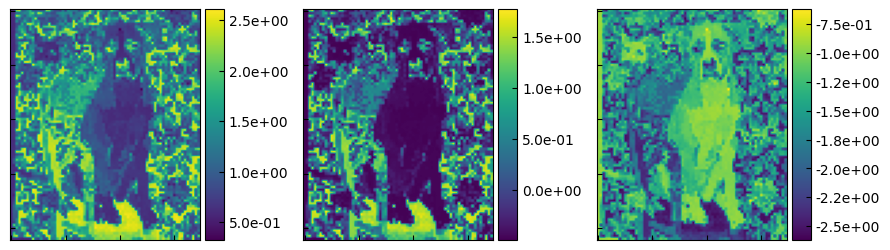

In [35]:
embedding_maps(encode, image)

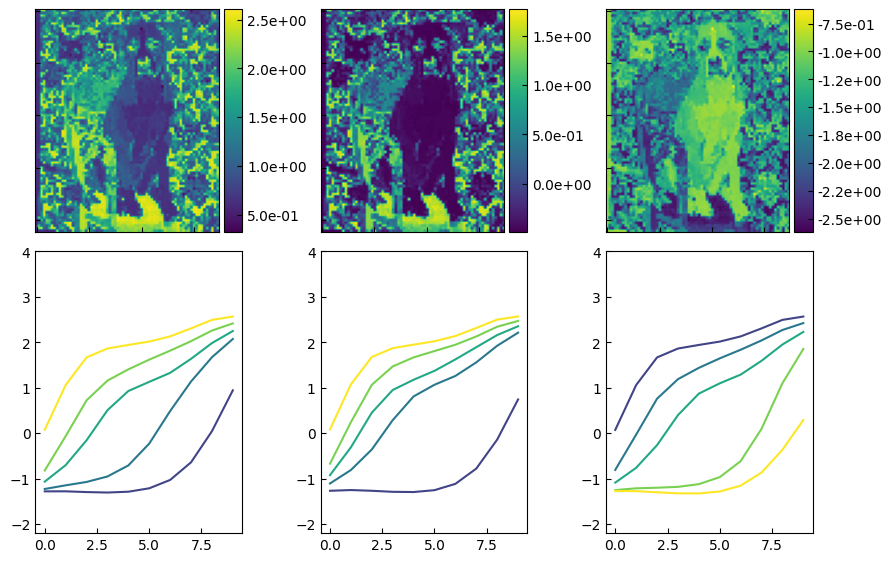

In [36]:
latent_generator(decoder, encode, image, 5, 10, device=device)

- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [37]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [38]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [39]:
model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [40]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [41]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3,
    mse=False,
    device=device,
)

  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 105.80it/s]

100%|██████████| 19/19 [00:00<00:00, 106.76it/s]

Epoch 0, Train Loss: 2.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.18it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 1, Train Loss: 2.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 117.26it/s]

Epoch 2, Train Loss: 2.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 3, Train Loss: 2.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 4, Train Loss: 2.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 119.68it/s]

100%|██████████| 19/19 [00:00<00:00, 119.20it/s]

Epoch 5, Train Loss: 2.1221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 6, Train Loss: 2.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 7, Train Loss: 2.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 8, Train Loss: 2.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 9, Train Loss: 2.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 10, Train Loss: 2.0917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 11, Train Loss: 2.0857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 12, Train Loss: 2.0798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 13, Train Loss: 2.0739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 114.44it/s]

Epoch 14, Train Loss: 2.0680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 15, Train Loss: 2.0621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 113.07it/s]

Epoch 16, Train Loss: 2.0563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 17, Train Loss: 2.0504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 18, Train Loss: 2.0445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.25it/s]

100%|██████████| 19/19 [00:00<00:00, 113.75it/s]

Epoch 19, Train Loss: 2.0386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.07it/s]

100%|██████████| 19/19 [00:00<00:00, 114.88it/s]

Epoch 20, Train Loss: 2.0327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.91it/s]

100%|██████████| 19/19 [00:00<00:00, 114.78it/s]

Epoch 21, Train Loss: 2.0268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 22, Train Loss: 2.0209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.12it/s]

Epoch 23, Train Loss: 2.0149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 24, Train Loss: 2.0089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 25, Train Loss: 2.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 26, Train Loss: 1.9967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 104.76it/s]

100%|██████████| 19/19 [00:00<00:00, 107.96it/s]

Epoch 27, Train Loss: 1.9906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 28, Train Loss: 1.9843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 29, Train Loss: 1.9780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 114.52it/s]

Epoch 30, Train Loss: 1.9716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 108.86it/s]

100%|██████████| 19/19 [00:00<00:00, 110.44it/s]

Epoch 31, Train Loss: 1.9652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 32, Train Loss: 1.9586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 33, Train Loss: 1.9523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 34, Train Loss: 1.9463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.55it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 35, Train Loss: 1.9405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 36, Train Loss: 1.9348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.96it/s]

100%|██████████| 19/19 [00:00<00:00, 116.40it/s]

Epoch 37, Train Loss: 1.9292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.46it/s]

100%|██████████| 19/19 [00:00<00:00, 115.82it/s]

Epoch 38, Train Loss: 1.9237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 114.45it/s]

Epoch 39, Train Loss: 1.9183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 40, Train Loss: 1.9129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.29it/s]

100%|██████████| 19/19 [00:00<00:00, 116.34it/s]

Epoch 41, Train Loss: 1.9076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 42, Train Loss: 1.9023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 43, Train Loss: 1.8974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 44, Train Loss: 1.8928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 45, Train Loss: 1.8883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 46, Train Loss: 1.8838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 47, Train Loss: 1.8794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 48, Train Loss: 1.8750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 49, Train Loss: 1.8705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 50, Train Loss: 1.8661
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.40it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 51, Train Loss: 1.8617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.22it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 52, Train Loss: 1.8572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 53, Train Loss: 1.8527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 54, Train Loss: 1.8482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 55, Train Loss: 1.8436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.85it/s]

Epoch 56, Train Loss: 1.8389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 107.87it/s]

100%|██████████| 19/19 [00:00<00:00, 108.59it/s]

Epoch 57, Train Loss: 1.8342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 111.76it/s]

Epoch 58, Train Loss: 1.8294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 59, Train Loss: 1.8245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 110.09it/s]

100%|██████████| 19/19 [00:00<00:00, 111.11it/s]

Epoch 60, Train Loss: 1.8196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 111.77it/s]

Epoch 61, Train Loss: 1.8146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.54it/s]

Epoch 62, Train Loss: 1.8095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 63, Train Loss: 1.8042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 64, Train Loss: 1.7989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 65, Train Loss: 1.7935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 66, Train Loss: 1.7880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.43it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 67, Train Loss: 1.7824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 68, Train Loss: 1.7767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 69, Train Loss: 1.7709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 70, Train Loss: 1.7650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.54it/s]

Epoch 71, Train Loss: 1.7589
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 72, Train Loss: 1.7527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 73, Train Loss: 1.7464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 74, Train Loss: 1.7400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 75, Train Loss: 1.7334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 76, Train Loss: 1.7266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 77, Train Loss: 1.7198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 78, Train Loss: 1.7127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 110.12it/s]

100%|██████████| 19/19 [00:00<00:00, 111.13it/s]

Epoch 79, Train Loss: 1.7056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 80, Train Loss: 1.6982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.18it/s]

100%|██████████| 19/19 [00:00<00:00, 111.78it/s]

Epoch 81, Train Loss: 1.6908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 82, Train Loss: 1.6832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 83, Train Loss: 1.6757
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 84, Train Loss: 1.6682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 85, Train Loss: 1.6607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 113.11it/s]

Epoch 86, Train Loss: 1.6531
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 87, Train Loss: 1.6453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 88, Train Loss: 1.6374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 89, Train Loss: 1.6294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 90, Train Loss: 1.6212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 91, Train Loss: 1.6129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.33it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 92, Train Loss: 1.6044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.20it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 93, Train Loss: 1.5959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 94, Train Loss: 1.5872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.56it/s]

100%|██████████| 19/19 [00:00<00:00, 115.89it/s]

Epoch 95, Train Loss: 1.5783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 96, Train Loss: 1.5694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.31it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 97, Train Loss: 1.5604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.53it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 98, Train Loss: 1.5513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 99, Train Loss: 1.5421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 100, Train Loss: 1.5328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 101, Train Loss: 1.5235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 102, Train Loss: 1.5141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.33it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 103, Train Loss: 1.5046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.18it/s]

100%|██████████| 19/19 [00:00<00:00, 112.45it/s]

Epoch 104, Train Loss: 1.4951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 105, Train Loss: 1.4856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 106, Train Loss: 1.4760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.84it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 107, Train Loss: 1.4664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 108, Train Loss: 1.4568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 111.14it/s]

100%|██████████| 19/19 [00:00<00:00, 113.11it/s]

Epoch 109, Train Loss: 1.4472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 110, Train Loss: 1.4376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.25it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 111, Train Loss: 1.4279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 112, Train Loss: 1.4183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 113, Train Loss: 1.4087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 114, Train Loss: 1.3991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 115, Train Loss: 1.3895
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 116, Train Loss: 1.3800
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 117, Train Loss: 1.3705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 118, Train Loss: 1.3610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 119, Train Loss: 1.3517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 120, Train Loss: 1.3423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 121, Train Loss: 1.3331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 122, Train Loss: 1.3239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 123, Train Loss: 1.3148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 124, Train Loss: 1.3058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 119.97it/s]

100%|██████████| 19/19 [00:00<00:00, 116.54it/s]

Epoch 125, Train Loss: 1.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 126, Train Loss: 1.2881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 127, Train Loss: 1.2794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 128, Train Loss: 1.2708
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 129, Train Loss: 1.2623
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 130, Train Loss: 1.2539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.27it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 131, Train Loss: 1.2457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 132, Train Loss: 1.2376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 133, Train Loss: 1.2297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 134, Train Loss: 1.2218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 135, Train Loss: 1.2141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 136, Train Loss: 1.2066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.66it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 137, Train Loss: 1.1992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 138, Train Loss: 1.1919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 112.44it/s]

Epoch 139, Train Loss: 1.1848
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.84it/s]

Epoch 140, Train Loss: 1.1778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 114.45it/s]

Epoch 141, Train Loss: 1.1710
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 142, Train Loss: 1.1642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.40it/s]

100%|██████████| 19/19 [00:00<00:00, 115.16it/s]

Epoch 143, Train Loss: 1.1576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.61it/s]

100%|██████████| 19/19 [00:00<00:00, 116.54it/s]

Epoch 144, Train Loss: 1.1511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.48it/s]

100%|██████████| 19/19 [00:00<00:00, 116.55it/s]

Epoch 145, Train Loss: 1.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 146, Train Loss: 1.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 147, Train Loss: 1.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 148, Train Loss: 1.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.37it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 149, Train Loss: 1.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 150, Train Loss: 1.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 151, Train Loss: 1.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.35it/s]

100%|██████████| 19/19 [00:00<00:00, 115.83it/s]

Epoch 152, Train Loss: 1.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.34it/s]

100%|██████████| 19/19 [00:00<00:00, 112.46it/s]

Epoch 153, Train Loss: 1.0948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.78it/s]

100%|██████████| 19/19 [00:00<00:00, 117.99it/s]

Epoch 154, Train Loss: 1.0884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 155, Train Loss: 1.0820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 156, Train Loss: 1.0758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 157, Train Loss: 1.0696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.30it/s]

Epoch 158, Train Loss: 1.0634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 159, Train Loss: 1.0571
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.82it/s]

100%|██████████| 19/19 [00:00<00:00, 118.02it/s]

Epoch 160, Train Loss: 1.0507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.82it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 161, Train Loss: 1.0442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 162, Train Loss: 1.0376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 163, Train Loss: 1.0308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 164, Train Loss: 1.0239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 165, Train Loss: 1.0167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 166, Train Loss: 1.0093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 167, Train Loss: 1.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 168, Train Loss: 0.9936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 169, Train Loss: 0.9852
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 170, Train Loss: 0.9765
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 171, Train Loss: 0.9674
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 172, Train Loss: 0.9578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 173, Train Loss: 0.9477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 174, Train Loss: 0.9371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 175, Train Loss: 0.9259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 176, Train Loss: 0.9140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 177, Train Loss: 0.9016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 178, Train Loss: 0.8886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 179, Train Loss: 0.8748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.66it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 180, Train Loss: 0.8605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 181, Train Loss: 0.8455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 182, Train Loss: 0.8301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 183, Train Loss: 0.8141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 184, Train Loss: 0.7978
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.49it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 185, Train Loss: 0.7813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.83it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 186, Train Loss: 0.7647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 187, Train Loss: 0.7481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.52it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 188, Train Loss: 0.7315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 189, Train Loss: 0.7152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 190, Train Loss: 0.6992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 191, Train Loss: 0.6836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 192, Train Loss: 0.6685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 193, Train Loss: 0.6539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 194, Train Loss: 0.6398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 195, Train Loss: 0.6262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 196, Train Loss: 0.6132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 197, Train Loss: 0.6008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 198, Train Loss: 0.5889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 199, Train Loss: 0.5778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 200, Train Loss: 0.5674
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 201, Train Loss: 0.5575
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 202, Train Loss: 0.5483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.69it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 203, Train Loss: 0.5396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 204, Train Loss: 0.5314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.83it/s]

Epoch 205, Train Loss: 0.5237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 206, Train Loss: 0.5164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 207, Train Loss: 0.5095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 208, Train Loss: 0.5029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 209, Train Loss: 0.4967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 210, Train Loss: 0.4907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 211, Train Loss: 0.4850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 212, Train Loss: 0.4796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 213, Train Loss: 0.4745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 113.12it/s]

Epoch 214, Train Loss: 0.4696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 215, Train Loss: 0.4649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 216, Train Loss: 0.4604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.25it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 217, Train Loss: 0.4560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 218, Train Loss: 0.4519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 219, Train Loss: 0.4479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.55it/s]

100%|██████████| 19/19 [00:00<00:00, 115.18it/s]

Epoch 220, Train Loss: 0.4441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 221, Train Loss: 0.4404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.19it/s]

100%|██████████| 19/19 [00:00<00:00, 112.45it/s]

Epoch 222, Train Loss: 0.4369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 223, Train Loss: 0.4334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 224, Train Loss: 0.4302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 225, Train Loss: 0.4270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 226, Train Loss: 0.4239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 227, Train Loss: 0.4210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 228, Train Loss: 0.4181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 229, Train Loss: 0.4153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 230, Train Loss: 0.4126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.12it/s]

Epoch 231, Train Loss: 0.4100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 232, Train Loss: 0.4075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 108.96it/s]

100%|██████████| 19/19 [00:00<00:00, 111.14it/s]

Epoch 233, Train Loss: 0.4050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.53it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 234, Train Loss: 0.4026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.43it/s]

100%|██████████| 19/19 [00:00<00:00, 113.78it/s]

Epoch 235, Train Loss: 0.4003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 236, Train Loss: 0.3980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 237, Train Loss: 0.3957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.69it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 238, Train Loss: 0.3936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 239, Train Loss: 0.3914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 240, Train Loss: 0.3893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 241, Train Loss: 0.3873
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 242, Train Loss: 0.3853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 243, Train Loss: 0.3834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 244, Train Loss: 0.3814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 245, Train Loss: 0.3796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.84it/s]

100%|██████████| 19/19 [00:00<00:00, 118.03it/s]

Epoch 246, Train Loss: 0.3777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.31it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 247, Train Loss: 0.3759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 248, Train Loss: 0.3741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 117.30it/s]

Epoch 249, Train Loss: 0.3724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 250, Train Loss: 0.3706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 251, Train Loss: 0.3689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 252, Train Loss: 0.3673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 253, Train Loss: 0.3656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 254, Train Loss: 0.3640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.53it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 255, Train Loss: 0.3624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 256, Train Loss: 0.3608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 257, Train Loss: 0.3593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.85it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 258, Train Loss: 0.3577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 259, Train Loss: 0.3562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.30it/s]

Epoch 260, Train Loss: 0.3548
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 261, Train Loss: 0.3533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 262, Train Loss: 0.3519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.58it/s]

Epoch 263, Train Loss: 0.3505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 264, Train Loss: 0.3491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 265, Train Loss: 0.3477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 266, Train Loss: 0.3464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.85it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 267, Train Loss: 0.3451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 268, Train Loss: 0.3438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.83it/s]

Epoch 269, Train Loss: 0.3426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 270, Train Loss: 0.3413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 271, Train Loss: 0.3401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.84it/s]

100%|██████████| 19/19 [00:00<00:00, 118.03it/s]

Epoch 272, Train Loss: 0.3390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.56it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 273, Train Loss: 0.3378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 274, Train Loss: 0.3367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 275, Train Loss: 0.3356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 276, Train Loss: 0.3345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.84it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 277, Train Loss: 0.3335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.79it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 278, Train Loss: 0.3324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 279, Train Loss: 0.3314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 121.49it/s]

100%|██████████| 19/19 [00:00<00:00, 120.28it/s]

Epoch 280, Train Loss: 0.3305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 119.30it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 281, Train Loss: 0.3295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 282, Train Loss: 0.3286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.62it/s]

100%|██████████| 19/19 [00:00<00:00, 116.55it/s]

Epoch 283, Train Loss: 0.3277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 119.99it/s]

100%|██████████| 19/19 [00:00<00:00, 119.49it/s]

Epoch 284, Train Loss: 0.3268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 285, Train Loss: 0.3259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 286, Train Loss: 0.3251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 287, Train Loss: 0.3243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 288, Train Loss: 0.3235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.79it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 289, Train Loss: 0.3227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 290, Train Loss: 0.3220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.67it/s]

100%|██████████| 19/19 [00:00<00:00, 118.03it/s]

Epoch 291, Train Loss: 0.3212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 119.50it/s]

Epoch 292, Train Loss: 0.3205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.02it/s]

Epoch 293, Train Loss: 0.3198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 294, Train Loss: 0.3191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.30it/s]

Epoch 295, Train Loss: 0.3184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 117.26it/s]

Epoch 296, Train Loss: 0.3178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 297, Train Loss: 0.3171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 118.03it/s]

Epoch 298, Train Loss: 0.3165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 299, Train Loss: 0.3159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 107.88it/s]

100%|██████████| 19/19 [00:00<00:00, 97.95it/s] 

Epoch 300, Train Loss: 0.3153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 106.76it/s]

100%|██████████| 19/19 [00:00<00:00, 110.45it/s]

Epoch 301, Train Loss: 0.3147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 302, Train Loss: 0.3142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 303, Train Loss: 0.3136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 304, Train Loss: 0.3131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 305, Train Loss: 0.3125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 306, Train Loss: 0.3120
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.18it/s]

100%|██████████| 19/19 [00:00<00:00, 113.07it/s]

Epoch 307, Train Loss: 0.3115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 110.48it/s]

Epoch 308, Train Loss: 0.3110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 103.82it/s]

Epoch 309, Train Loss: 0.3105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 102.80it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 310, Train Loss: 0.3100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 108.91it/s]

100%|██████████| 19/19 [00:00<00:00, 111.09it/s]

Epoch 311, Train Loss: 0.3095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 312, Train Loss: 0.3090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 313, Train Loss: 0.3085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 314, Train Loss: 0.3080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 315, Train Loss: 0.3076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 316, Train Loss: 0.3071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 317, Train Loss: 0.3067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 318, Train Loss: 0.3062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.80it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 319, Train Loss: 0.3058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.61it/s]

100%|██████████| 19/19 [00:00<00:00, 117.26it/s]

Epoch 320, Train Loss: 0.3053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.82it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 321, Train Loss: 0.3049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 322, Train Loss: 0.3045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 323, Train Loss: 0.3040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 324, Train Loss: 0.3036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 325, Train Loss: 0.3032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.83it/s]

Epoch 326, Train Loss: 0.3027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 327, Train Loss: 0.3023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 328, Train Loss: 0.3019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 329, Train Loss: 0.3015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 330, Train Loss: 0.3011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 331, Train Loss: 0.3006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 332, Train Loss: 0.3002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 333, Train Loss: 0.2998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 334, Train Loss: 0.2994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.18it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 335, Train Loss: 0.2990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 336, Train Loss: 0.2986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 337, Train Loss: 0.2981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 338, Train Loss: 0.2977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.83it/s]

100%|██████████| 19/19 [00:00<00:00, 118.76it/s]

Epoch 339, Train Loss: 0.2973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 340, Train Loss: 0.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 341, Train Loss: 0.2965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.82it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 342, Train Loss: 0.2961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 343, Train Loss: 0.2957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 344, Train Loss: 0.2953
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 345, Train Loss: 0.2949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 346, Train Loss: 0.2945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 347, Train Loss: 0.2940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 104.79it/s]

100%|██████████| 19/19 [00:00<00:00, 96.46it/s] 

Epoch 348, Train Loss: 0.2936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 106.76it/s]

100%|██████████| 19/19 [00:00<00:00, 110.44it/s]

Epoch 349, Train Loss: 0.2932
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 350, Train Loss: 0.2928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 351, Train Loss: 0.2924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 352, Train Loss: 0.2920
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 353, Train Loss: 0.2916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 354, Train Loss: 0.2912
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.25it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 355, Train Loss: 0.2908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 356, Train Loss: 0.2904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 357, Train Loss: 0.2900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 111.11it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 358, Train Loss: 0.2896
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 359, Train Loss: 0.2892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 360, Train Loss: 0.2888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 361, Train Loss: 0.2884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.44it/s]

100%|██████████| 19/19 [00:00<00:00, 115.89it/s]

Epoch 362, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 363, Train Loss: 0.2876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 364, Train Loss: 0.2872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 365, Train Loss: 0.2868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.89it/s]

100%|██████████| 19/19 [00:00<00:00, 95.98it/s] 

Epoch 366, Train Loss: 0.2865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 367, Train Loss: 0.2861
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 368, Train Loss: 0.2857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 369, Train Loss: 0.2853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.69it/s]

100%|██████████| 19/19 [00:00<00:00, 118.04it/s]

Epoch 370, Train Loss: 0.2849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.55it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 371, Train Loss: 0.2845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 372, Train Loss: 0.2841
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 373, Train Loss: 0.2837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 113.10it/s]

Epoch 374, Train Loss: 0.2833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 375, Train Loss: 0.2829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 109.83it/s]

Epoch 376, Train Loss: 0.2825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 111.14it/s]

100%|██████████| 19/19 [00:00<00:00, 112.45it/s]

Epoch 377, Train Loss: 0.2821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 378, Train Loss: 0.2818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 379, Train Loss: 0.2814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 380, Train Loss: 0.2810
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.24it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 381, Train Loss: 0.2806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 382, Train Loss: 0.2802
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 97.45it/s] 

Epoch 383, Train Loss: 0.2798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 105.56it/s]

Epoch 384, Train Loss: 0.2794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 385, Train Loss: 0.2790
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 106.80it/s]

100%|██████████| 19/19 [00:00<00:00, 110.47it/s]

Epoch 386, Train Loss: 0.2787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.56it/s]

100%|██████████| 19/19 [00:00<00:00, 115.18it/s]

Epoch 387, Train Loss: 0.2783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 388, Train Loss: 0.2779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 389, Train Loss: 0.2775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 390, Train Loss: 0.2771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 391, Train Loss: 0.2767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 392, Train Loss: 0.2763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 112.42it/s]

Epoch 393, Train Loss: 0.2760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 111.78it/s]

Epoch 394, Train Loss: 0.2756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 395, Train Loss: 0.2752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 396, Train Loss: 0.2748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 397, Train Loss: 0.2744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 398, Train Loss: 0.2740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 399, Train Loss: 0.2736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 400, Train Loss: 0.2733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 401, Train Loss: 0.2729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 402, Train Loss: 0.2725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 111.13it/s]

Epoch 403, Train Loss: 0.2721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

100%|██████████| 19/19 [00:00<00:00, 94.53it/s]

Epoch 404, Train Loss: 0.2717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 405, Train Loss: 0.2713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 406, Train Loss: 0.2710
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 407, Train Loss: 0.2706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.43it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 408, Train Loss: 0.2702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 409, Train Loss: 0.2698
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.41it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 410, Train Loss: 0.2694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.54it/s]

100%|██████████| 19/19 [00:00<00:00, 115.87it/s]

Epoch 411, Train Loss: 0.2691
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 412, Train Loss: 0.2687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.25it/s]

100%|██████████| 19/19 [00:00<00:00, 113.80it/s]

Epoch 413, Train Loss: 0.2683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.32it/s]

100%|██████████| 19/19 [00:00<00:00, 115.17it/s]

Epoch 414, Train Loss: 0.2679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 415, Train Loss: 0.2675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.77it/s]

Epoch 416, Train Loss: 0.2672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 417, Train Loss: 0.2668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.29it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 418, Train Loss: 0.2664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.42it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 419, Train Loss: 0.2660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.09it/s]

Epoch 420, Train Loss: 0.2656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.55it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 421, Train Loss: 0.2652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 112.15it/s]

100%|██████████| 19/19 [00:00<00:00, 111.76it/s]

Epoch 422, Train Loss: 0.2649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 423, Train Loss: 0.2645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 119.30it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 424, Train Loss: 0.2641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.84it/s]

100%|██████████| 19/19 [00:00<00:00, 118.77it/s]

Epoch 425, Train Loss: 0.2637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.68it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 426, Train Loss: 0.2633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 427, Train Loss: 0.2630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 428, Train Loss: 0.2626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 121.49it/s]

100%|██████████| 19/19 [00:00<00:00, 120.25it/s]

Epoch 429, Train Loss: 0.2622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 430, Train Loss: 0.2618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.16it/s]

Epoch 431, Train Loss: 0.2614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 432, Train Loss: 0.2611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.21it/s]

100%|██████████| 19/19 [00:00<00:00, 113.79it/s]

Epoch 433, Train Loss: 0.2607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s] 

Epoch 434, Train Loss: 0.2603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.25it/s]

100%|██████████| 19/19 [00:00<00:00, 114.43it/s]

Epoch 435, Train Loss: 0.2599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 114.48it/s]

Epoch 436, Train Loss: 0.2595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.48it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 437, Train Loss: 0.2591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.86it/s]

Epoch 438, Train Loss: 0.2588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 439, Train Loss: 0.2584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 440, Train Loss: 0.2580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 441, Train Loss: 0.2576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 109.12it/s]

100%|██████████| 19/19 [00:00<00:00, 100.54it/s]

Epoch 442, Train Loss: 0.2572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 107.81it/s]

100%|██████████| 19/19 [00:00<00:00, 110.45it/s]

Epoch 443, Train Loss: 0.2568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 444, Train Loss: 0.2564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 445, Train Loss: 0.2561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 446, Train Loss: 0.2557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 447, Train Loss: 0.2553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.59it/s]

Epoch 448, Train Loss: 0.2549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 114.46it/s]

Epoch 449, Train Loss: 0.2545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 450, Train Loss: 0.2541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 451, Train Loss: 0.2538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.88it/s]

Epoch 452, Train Loss: 0.2534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 111.08it/s]

100%|██████████| 19/19 [00:00<00:00, 113.08it/s]

Epoch 453, Train Loss: 0.2530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 113.23it/s]

100%|██████████| 19/19 [00:00<00:00, 111.13it/s]

Epoch 454, Train Loss: 0.2526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.35it/s]

100%|██████████| 19/19 [00:00<00:00, 115.13it/s]

Epoch 455, Train Loss: 0.2522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 456, Train Loss: 0.2518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.85it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 457, Train Loss: 0.2514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.38it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 458, Train Loss: 0.2511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.83it/s]

100%|██████████| 19/19 [00:00<00:00, 118.76it/s]

Epoch 459, Train Loss: 0.2507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.52it/s]

100%|██████████| 19/19 [00:00<00:00, 117.31it/s]

Epoch 460, Train Loss: 0.2503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.77it/s]

100%|██████████| 19/19 [00:00<00:00, 116.54it/s]

Epoch 461, Train Loss: 0.2499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 462, Train Loss: 0.2495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 463, Train Loss: 0.2491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 464, Train Loss: 0.2488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 465, Train Loss: 0.2484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 466, Train Loss: 0.2480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 110.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s] 

Epoch 467, Train Loss: 0.2476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 105.74it/s]

100%|██████████| 19/19 [00:00<00:00, 108.55it/s]

Epoch 468, Train Loss: 0.2472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 469, Train Loss: 0.2469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.40it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 470, Train Loss: 0.2465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 471, Train Loss: 0.2461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 472, Train Loss: 0.2457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.55it/s]

100%|██████████| 19/19 [00:00<00:00, 115.18it/s]

Epoch 473, Train Loss: 0.2453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 474, Train Loss: 0.2450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 114.28it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 475, Train Loss: 0.2446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 476, Train Loss: 0.2442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 116.57it/s]

Epoch 477, Train Loss: 0.2438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.50it/s]

100%|██████████| 19/19 [00:00<00:00, 115.15it/s]

Epoch 478, Train Loss: 0.2435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 479, Train Loss: 0.2431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 115.39it/s]

100%|██████████| 19/19 [00:00<00:00, 115.85it/s]

Epoch 480, Train Loss: 0.2427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 119.99it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 481, Train Loss: 0.2424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 482, Train Loss: 0.2420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 483, Train Loss: 0.2416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.47it/s]

100%|██████████| 19/19 [00:00<00:00, 115.83it/s]

Epoch 484, Train Loss: 0.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 485, Train Loss: 0.2409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.64it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 486, Train Loss: 0.2405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 487, Train Loss: 0.2401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 117.28it/s]

Epoch 488, Train Loss: 0.2398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 120.37it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 489, Train Loss: 0.2394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 120.37it/s]

100%|██████████| 19/19 [00:00<00:00, 119.50it/s]

Epoch 490, Train Loss: 0.2391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 119.99it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 491, Train Loss: 0.2387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 68%|██████▊   | 13/19 [00:00<00:00, 119.28it/s]

100%|██████████| 19/19 [00:00<00:00, 118.76it/s]

Epoch 492, Train Loss: 0.2383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 118.75it/s]

Epoch 493, Train Loss: 0.2380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.66it/s]

100%|██████████| 19/19 [00:00<00:00, 117.29it/s]

Epoch 494, Train Loss: 0.2376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 118.81it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 495, Train Loss: 0.2373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 496, Train Loss: 0.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 117.65it/s]

100%|██████████| 19/19 [00:00<00:00, 117.30it/s]

Epoch 497, Train Loss: 0.2366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 116.51it/s]

100%|██████████| 19/19 [00:00<00:00, 116.56it/s]

Epoch 498, Train Loss: 0.2362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 63%|██████▎   | 12/19 [00:00<00:00, 120.00it/s]

100%|██████████| 19/19 [00:00<00:00, 118.01it/s]

Epoch 499, Train Loss: 0.2358
.............................


### Validation


In [42]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

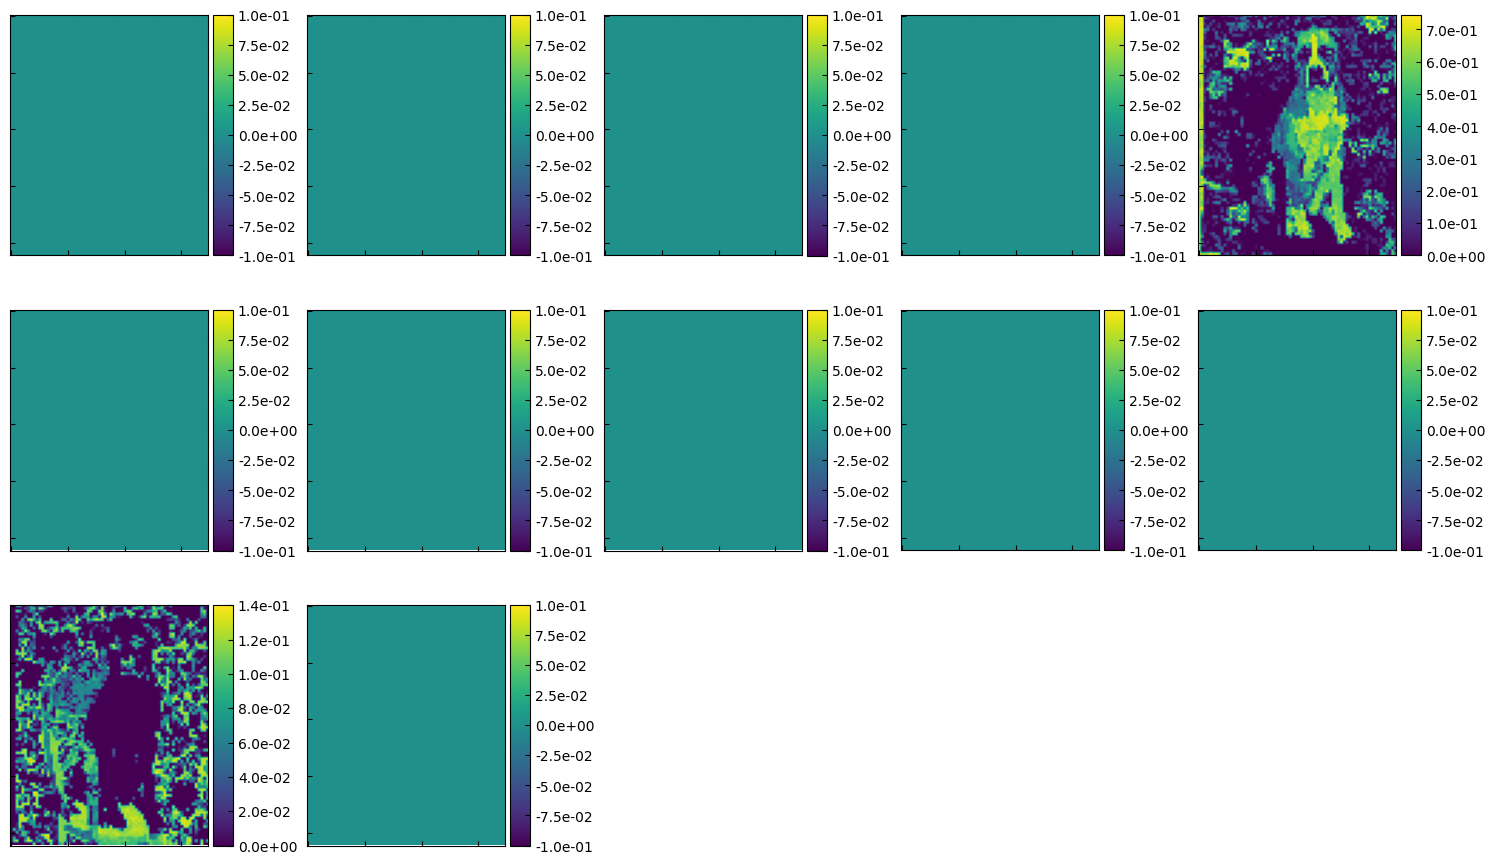

In [43]:
embedding_maps(encode, image)

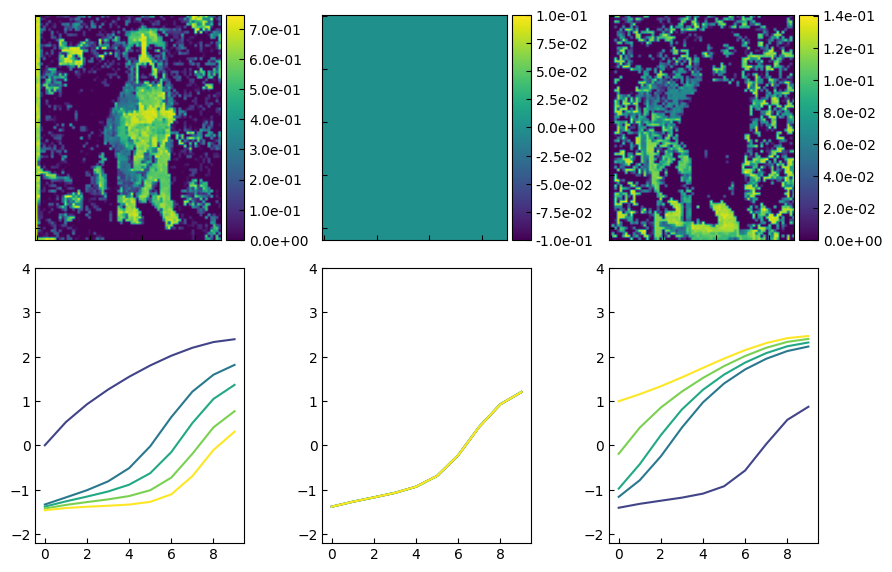

In [44]:
latent_generator(decoder, encode, image, 5, 10, indx=[4, 3, 10], device=device)

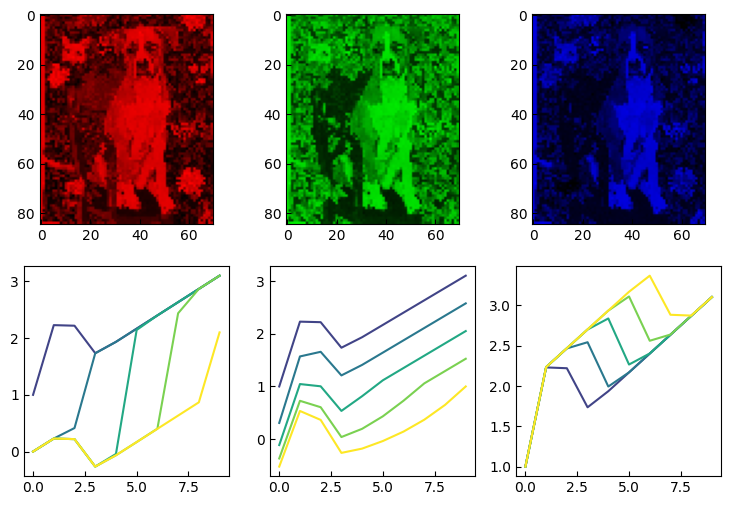

In [45]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)

In [46]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

C:\Users\Joshua Agar\.conda\envs\m3_learning\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Beta Variational Autoencoder

- Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution


### Normal Autoencoder

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE1.png?raw=true)


### VAE

- Encoder identifies some distribution --> generates from that distribution
  ![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE2.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE3.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE4.png?raw=true)


### Builds the Model


In [47]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [48]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

### Training


In [49]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) // epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if (
            (epoch - initial_epochs) // epoch_per_beta
            == (epoch - initial_epochs) / epoch_per_beta
        ) and (epoch >= initial_epochs):

            best_train_loss = float("inf")

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
            }
            if epoch >= 0:
                torch.save(
                    checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                )

In [50]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)

  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 87.50it/s]

100%|██████████| 19/19 [00:00<00:00, 89.56it/s]

100%|██████████| 19/19 [00:00<00:00, 88.84it/s]

Epoch 0, Train Loss: 2.1055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 87.99it/s]

100%|██████████| 19/19 [00:00<00:00, 91.27it/s]

100%|██████████| 19/19 [00:00<00:00, 90.79it/s]

Epoch 1, Train Loss: 2.0683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 2, Train Loss: 2.0328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 3, Train Loss: 2.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 4, Train Loss: 1.9607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 75.47it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 82.86it/s]

100%|██████████| 19/19 [00:00<00:00, 82.61it/s]

Epoch 5, Train Loss: 1.9102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 6, Train Loss: 1.8534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 7, Train Loss: 1.7744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 8, Train Loss: 1.6892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.00it/s]

100%|██████████| 19/19 [00:00<00:00, 97.84it/s]

Epoch 9, Train Loss: 1.5761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.06it/s]

100%|██████████| 19/19 [00:00<00:00, 98.47it/s]

Epoch 10, Train Loss: 1.4694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 11, Train Loss: 1.3667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 12, Train Loss: 1.2435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 13, Train Loss: 1.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 14, Train Loss: 1.0432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 82.97it/s]

Epoch 15, Train Loss: 0.9562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

100%|██████████| 19/19 [00:00<00:00, 90.66it/s]

100%|██████████| 19/19 [00:00<00:00, 89.19it/s]

Epoch 16, Train Loss: 0.8767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 17, Train Loss: 0.7903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 93.58it/s]

Epoch 18, Train Loss: 0.7102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.49it/s]

100%|██████████| 19/19 [00:00<00:00, 95.98it/s]

Epoch 19, Train Loss: 0.6191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 90.91it/s]

100%|██████████| 19/19 [00:00<00:00, 84.44it/s]

Epoch 20, Train Loss: 0.5343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 91.75it/s]

100%|██████████| 19/19 [00:00<00:00, 94.06it/s]

Epoch 21, Train Loss: 0.4568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.25it/s]

100%|██████████| 19/19 [00:00<00:00, 96.55it/s]

Epoch 22, Train Loss: 0.3811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 23, Train Loss: 0.3270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 24, Train Loss: 0.2903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.95it/s]

Epoch 25, Train Loss: 0.2678
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 26, Train Loss: 0.2524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 27, Train Loss: 0.2430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 89.11it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 86.59it/s]

100%|██████████| 19/19 [00:00<00:00, 86.36it/s]

Epoch 28, Train Loss: 0.2323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 90.00it/s]

100%|██████████| 19/19 [00:00<00:00, 94.22it/s]

100%|██████████| 19/19 [00:00<00:00, 93.14it/s]

Epoch 29, Train Loss: 0.2246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 30, Train Loss: 0.2180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.63it/s]

100%|██████████| 19/19 [00:00<00:00, 96.17it/s]

Epoch 31, Train Loss: 0.2118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 95.94it/s]

Epoch 32, Train Loss: 0.2067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 33, Train Loss: 0.2031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.92it/s]

100%|██████████| 19/19 [00:00<00:00, 96.85it/s]

Epoch 34, Train Loss: 0.1971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.40it/s]

100%|██████████| 19/19 [00:00<00:00, 97.60it/s]

Epoch 35, Train Loss: 0.1941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 95.96it/s]

Epoch 36, Train Loss: 0.1889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 37, Train Loss: 0.1866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 38, Train Loss: 0.1833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 39, Train Loss: 0.1795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 40, Train Loss: 0.1766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.54it/s] 

Epoch 41, Train Loss: 0.1738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.89it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 42, Train Loss: 0.1705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.54it/s]

100%|██████████| 19/19 [00:00<00:00, 101.43it/s]

Epoch 43, Train Loss: 0.1681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.39it/s]

100%|██████████| 19/19 [00:00<00:00, 101.28it/s]

Epoch 44, Train Loss: 0.1656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.66it/s]

100%|██████████| 19/19 [00:00<00:00, 91.64it/s]

Epoch 45, Train Loss: 0.1624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 88.23it/s]

100%|██████████| 19/19 [00:00<00:00, 93.45it/s]

100%|██████████| 19/19 [00:00<00:00, 92.22it/s]

Epoch 46, Train Loss: 0.1593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.98it/s]

100%|██████████| 19/19 [00:00<00:00, 98.97it/s]

Epoch 47, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.13it/s]

100%|██████████| 19/19 [00:00<00:00, 97.18it/s]

Epoch 48, Train Loss: 0.1542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 49, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.46it/s] 

Epoch 50, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.45it/s]

100%|██████████| 19/19 [00:00<00:00, 97.63it/s]

Epoch 51, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 52, Train Loss: 0.1432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 53, Train Loss: 0.1401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 98.22it/s]

100%|██████████| 19/19 [00:00<00:00, 98.57it/s]

Epoch 54, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.25it/s]

100%|██████████| 19/19 [00:00<00:00, 100.15it/s]

Epoch 55, Train Loss: 0.1353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.14it/s]

100%|██████████| 19/19 [00:00<00:00, 98.46it/s]

Epoch 56, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.55it/s]

Epoch 57, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.95it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 58, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 101.60it/s]

Epoch 59, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.91it/s]

100%|██████████| 19/19 [00:00<00:00, 100.54it/s]

Epoch 60, Train Loss: 0.1251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 61, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.13it/s]

100%|██████████| 19/19 [00:00<00:00, 100.60it/s]

Epoch 62, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.17it/s]

100%|██████████| 19/19 [00:00<00:00, 100.09it/s]

Epoch 63, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 64, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 76.27it/s]

100%|██████████| 19/19 [00:00<00:00, 84.20it/s]

100%|██████████| 19/19 [00:00<00:00, 82.61it/s]

Epoch 65, Train Loss: 0.1174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 66, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 67, Train Loss: 0.1149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 68, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 69, Train Loss: 0.1128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 70, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.58it/s]

Epoch 71, Train Loss: 0.1105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 72, Train Loss: 0.1093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 73, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 74, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 75, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 76, Train Loss: 0.1046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 77, Train Loss: 0.1033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 78, Train Loss: 0.1021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 79, Train Loss: 0.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 80, Train Loss: 0.0992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 81, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 82, Train Loss: 0.0961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.03it/s]

100%|██████████| 19/19 [00:00<00:00, 100.01it/s]

Epoch 83, Train Loss: 0.0942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.41it/s]

100%|██████████| 19/19 [00:00<00:00, 99.69it/s]

Epoch 84, Train Loss: 0.0924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.02it/s]

Epoch 85, Train Loss: 0.0903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.03it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 86, Train Loss: 0.0882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 90.91it/s]

Epoch 87, Train Loss: 0.0859
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 90.00it/s]

100%|██████████| 19/19 [00:00<00:00, 94.77it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 88, Train Loss: 0.0838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.20it/s]

100%|██████████| 19/19 [00:00<00:00, 96.92it/s]

Epoch 89, Train Loss: 0.0812
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.09it/s]

100%|██████████| 19/19 [00:00<00:00, 95.03it/s]

Epoch 90, Train Loss: 0.0786
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.98it/s]

100%|██████████| 19/19 [00:00<00:00, 98.94it/s]

Epoch 91, Train Loss: 0.0762
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.07it/s]

100%|██████████| 19/19 [00:00<00:00, 98.87it/s]

Epoch 92, Train Loss: 0.0744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 93, Train Loss: 0.0727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 94, Train Loss: 0.0713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 95, Train Loss: 0.0700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 90.48it/s]

Epoch 96, Train Loss: 0.0689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 89.11it/s]

100%|██████████| 19/19 [00:00<00:00, 93.30it/s]

100%|██████████| 19/19 [00:00<00:00, 92.68it/s]

Epoch 97, Train Loss: 0.0679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 98, Train Loss: 0.0668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 99, Train Loss: 0.0657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 100, Train Loss: 0.0647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 101, Train Loss: 0.0638
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 102, Train Loss: 0.0629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.53it/s]

100%|██████████| 19/19 [00:00<00:00, 97.69it/s]

Epoch 103, Train Loss: 0.0620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s]

Epoch 104, Train Loss: 0.0611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 105, Train Loss: 0.0604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.48it/s]

100%|██████████| 19/19 [00:00<00:00, 96.62it/s]

Epoch 106, Train Loss: 0.0596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 94.34it/s]

100%|██████████| 19/19 [00:00<00:00, 95.96it/s]

Epoch 107, Train Loss: 0.0587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 108, Train Loss: 0.0580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 109, Train Loss: 0.0573
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.46it/s]

100%|██████████| 19/19 [00:00<00:00, 95.00it/s]

Epoch 110, Train Loss: 0.0564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.59it/s]

100%|██████████| 19/19 [00:00<00:00, 97.17it/s]

Epoch 111, Train Loss: 0.0558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.27it/s]

100%|██████████| 19/19 [00:00<00:00, 96.96it/s]

Epoch 112, Train Loss: 0.0551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.02it/s]

100%|██████████| 19/19 [00:00<00:00, 99.50it/s]

Epoch 113, Train Loss: 0.0545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.95it/s]

100%|██████████| 19/19 [00:00<00:00, 97.89it/s]

Epoch 114, Train Loss: 0.0538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.69it/s]

100%|██████████| 19/19 [00:00<00:00, 99.31it/s]

Epoch 115, Train Loss: 0.0530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.15it/s]

100%|██████████| 19/19 [00:00<00:00, 99.08it/s]

Epoch 116, Train Loss: 0.0524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.32it/s]

100%|██████████| 19/19 [00:00<00:00, 99.21it/s]

Epoch 117, Train Loss: 0.0517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.46it/s] 

Epoch 118, Train Loss: 0.0511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.71it/s]

100%|██████████| 19/19 [00:00<00:00, 99.85it/s]

Epoch 119, Train Loss: 0.0505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 120, Train Loss: 0.0498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 121, Train Loss: 0.0493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 94.34it/s]

100%|██████████| 19/19 [00:00<00:00, 95.96it/s]

Epoch 122, Train Loss: 0.0487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 123, Train Loss: 0.0480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 124, Train Loss: 0.0474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 125, Train Loss: 0.0469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 126, Train Loss: 0.0463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 127, Train Loss: 0.0456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.06it/s]

100%|██████████| 19/19 [00:00<00:00, 99.11it/s]

Epoch 128, Train Loss: 0.0452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.99it/s]

100%|██████████| 19/19 [00:00<00:00, 99.47it/s]

Epoch 129, Train Loss: 0.0445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.03it/s]

100%|██████████| 19/19 [00:00<00:00, 98.95it/s]

Epoch 130, Train Loss: 0.0440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.89it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s] 

Epoch 131, Train Loss: 0.0435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.98it/s]

100%|██████████| 19/19 [00:00<00:00, 98.94it/s]

Epoch 132, Train Loss: 0.0429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.03it/s]

100%|██████████| 19/19 [00:00<00:00, 99.99it/s] 

Epoch 133, Train Loss: 0.0423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 134, Train Loss: 0.0418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.44it/s]

100%|██████████| 19/19 [00:00<00:00, 96.23it/s] 

Epoch 135, Train Loss: 0.0412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 76.92it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 88.74it/s]

100%|██████████| 19/19 [00:00<00:00, 87.16it/s]

Epoch 136, Train Loss: 0.0407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.89it/s]

100%|██████████| 19/19 [00:00<00:00, 99.45it/s] 

Epoch 137, Train Loss: 0.0402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.27it/s]

100%|██████████| 19/19 [00:00<00:00, 96.95it/s]

Epoch 138, Train Loss: 0.0398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 139, Train Loss: 0.0391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 140, Train Loss: 0.0387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.65it/s] 

Epoch 141, Train Loss: 0.0382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.06it/s]

100%|██████████| 19/19 [00:00<00:00, 98.47it/s]

Epoch 142, Train Loss: 0.0377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.05it/s]

100%|██████████| 19/19 [00:00<00:00, 97.42it/s]

Epoch 143, Train Loss: 0.0371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 144, Train Loss: 0.0366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 145, Train Loss: 0.0361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s] 

Epoch 146, Train Loss: 0.0356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.56it/s]

Epoch 147, Train Loss: 0.0351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.98it/s] 

Epoch 148, Train Loss: 0.0347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.14it/s]

100%|██████████| 19/19 [00:00<00:00, 97.93it/s]

Epoch 149, Train Loss: 0.0343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.04it/s]

100%|██████████| 19/19 [00:00<00:00, 99.49it/s]

Epoch 150, Train Loss: 0.0337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.97it/s]

100%|██████████| 19/19 [00:00<00:00, 99.46it/s]

Epoch 151, Train Loss: 0.0334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 152, Train Loss: 0.0329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.97it/s]

Epoch 153, Train Loss: 0.0325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 154, Train Loss: 0.0321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.98it/s] 

Epoch 155, Train Loss: 0.0318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.87it/s]

100%|██████████| 19/19 [00:00<00:00, 98.89it/s]

Epoch 156, Train Loss: 0.0312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 157, Train Loss: 0.0309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 158, Train Loss: 0.0305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 159, Train Loss: 0.0301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 160, Train Loss: 0.0298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 161, Train Loss: 0.0294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 162, Train Loss: 0.0291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 163, Train Loss: 0.0286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 164, Train Loss: 0.0283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.13it/s]

100%|██████████| 19/19 [00:00<00:00, 98.47it/s]

Epoch 165, Train Loss: 0.0280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 166, Train Loss: 0.0277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 83.70it/s]

100%|██████████| 19/19 [00:00<00:00, 83.33it/s]

Epoch 167, Train Loss: 0.0272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.46it/s]

100%|██████████| 19/19 [00:00<00:00, 95.46it/s]

Epoch 168, Train Loss: 0.0269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 169, Train Loss: 0.0265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.01it/s]

100%|██████████| 19/19 [00:00<00:00, 96.43it/s]

Epoch 170, Train Loss: 0.0262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 171, Train Loss: 0.0258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.43it/s]

100%|██████████| 19/19 [00:00<00:00, 93.58it/s]

Epoch 172, Train Loss: 0.0254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.43it/s]

100%|██████████| 19/19 [00:00<00:00, 94.05it/s]

Epoch 173, Train Loss: 0.0250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 174, Train Loss: 0.0247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.00it/s]

Epoch 175, Train Loss: 0.0243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 87.96it/s]

Epoch 176, Train Loss: 0.0239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 79.21it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 87.77it/s]

100%|██████████| 19/19 [00:00<00:00, 86.35it/s]

Epoch 177, Train Loss: 0.0235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

100%|██████████| 19/19 [00:00<00:00, 94.53it/s]

Epoch 178, Train Loss: 0.0232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 94.30it/s]

100%|██████████| 19/19 [00:00<00:00, 93.58it/s]

Epoch 179, Train Loss: 0.0228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 93.14it/s]

Epoch 180, Train Loss: 0.0224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.46it/s]

100%|██████████| 19/19 [00:00<00:00, 92.68it/s]

Epoch 181, Train Loss: 0.0222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.57it/s]

100%|██████████| 19/19 [00:00<00:00, 93.14it/s]

Epoch 182, Train Loss: 0.0217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 94.31it/s]

100%|██████████| 19/19 [00:00<00:00, 94.05it/s]

Epoch 183, Train Loss: 0.0214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.43it/s]

100%|██████████| 19/19 [00:00<00:00, 93.12it/s]

Epoch 184, Train Loss: 0.0211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.48it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 185, Train Loss: 0.0209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

100%|██████████| 19/19 [00:00<00:00, 93.58it/s]

Epoch 186, Train Loss: 0.0205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 93.60it/s]

Epoch 187, Train Loss: 0.0202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

100%|██████████| 19/19 [00:00<00:00, 95.00it/s]

Epoch 188, Train Loss: 0.0199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.12it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 189, Train Loss: 0.0197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.49it/s]

Epoch 190, Train Loss: 0.0196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 94.06it/s]

Epoch 191, Train Loss: 0.0193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 192, Train Loss: 0.0191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 193, Train Loss: 0.0188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.96it/s]

Epoch 194, Train Loss: 0.0186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

100%|██████████| 19/19 [00:00<00:00, 95.95it/s]

Epoch 195, Train Loss: 0.0184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 196, Train Loss: 0.0182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.04it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 197, Train Loss: 0.0181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.95it/s]

100%|██████████| 19/19 [00:00<00:00, 101.08it/s]

Epoch 198, Train Loss: 0.0178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.51it/s]

Epoch 199, Train Loss: 0.0176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.07it/s]

100%|██████████| 19/19 [00:00<00:00, 98.46it/s]

Epoch 200, Train Loss: 1.7396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.89it/s]

100%|██████████| 19/19 [00:00<00:00, 101.05it/s]

Epoch 201, Train Loss: 0.8116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 202, Train Loss: 0.4598
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 203, Train Loss: 0.3415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.97it/s]

100%|██████████| 19/19 [00:00<00:00, 101.05it/s]

Epoch 204, Train Loss: 0.3064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 205, Train Loss: 0.2877
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 206, Train Loss: 0.2756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.82it/s]

100%|██████████| 19/19 [00:00<00:00, 101.60it/s]

Epoch 207, Train Loss: 0.2701
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 208, Train Loss: 0.2586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 209, Train Loss: 0.2554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 210, Train Loss: 0.2489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 85.59it/s]

Epoch 211, Train Loss: 0.2436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 95.46it/s]

Epoch 212, Train Loss: 0.2406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.99it/s]

Epoch 213, Train Loss: 0.2362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 214, Train Loss: 0.2344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.97it/s]

100%|██████████| 19/19 [00:00<00:00, 100.51it/s]

Epoch 215, Train Loss: 0.2297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.98it/s]

100%|██████████| 19/19 [00:00<00:00, 99.46it/s]

Epoch 216, Train Loss: 0.2295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 217, Train Loss: 0.2249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 218, Train Loss: 0.2226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 219, Train Loss: 0.2175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.97it/s]

100%|██████████| 19/19 [00:00<00:00, 99.98it/s]

Epoch 220, Train Loss: 0.2171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.08it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 221, Train Loss: 0.2140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.98it/s]

100%|██████████| 19/19 [00:00<00:00, 99.46it/s]

Epoch 222, Train Loss: 0.2107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.98it/s] 

Epoch 223, Train Loss: 0.2103
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 224, Train Loss: 0.2088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.43it/s]

Epoch 225, Train Loss: 0.2066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s] 

Epoch 226, Train Loss: 0.2045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 67.96it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 81.82it/s]

100%|██████████| 19/19 [00:00<00:00, 80.85it/s]

Epoch 227, Train Loss: 0.2040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 228, Train Loss: 0.2007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.85it/s]

100%|██████████| 19/19 [00:00<00:00, 95.84it/s]

Epoch 229, Train Loss: 0.1979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.96it/s]

Epoch 230, Train Loss: 0.1964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 231, Train Loss: 0.1936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.23it/s]

100%|██████████| 19/19 [00:00<00:00, 95.98it/s]

Epoch 232, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.78it/s]

100%|██████████| 19/19 [00:00<00:00, 97.32it/s]

Epoch 233, Train Loss: 0.1907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 234, Train Loss: 0.1894
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

100%|██████████| 19/19 [00:00<00:00, 94.06it/s]

Epoch 235, Train Loss: 0.1870
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 94.98it/s]

Epoch 236, Train Loss: 0.1859
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.12it/s]

100%|██████████| 19/19 [00:00<00:00, 97.87it/s]

Epoch 237, Train Loss: 0.1855
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.62it/s]

100%|██████████| 19/19 [00:00<00:00, 96.72it/s]

Epoch 238, Train Loss: 0.1826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.43it/s]

Epoch 239, Train Loss: 0.1819
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.19it/s]

100%|██████████| 19/19 [00:00<00:00, 96.91it/s]

Epoch 240, Train Loss: 0.1808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.00it/s]

100%|██████████| 19/19 [00:00<00:00, 97.92it/s]

Epoch 241, Train Loss: 0.1785
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.12it/s]

100%|██████████| 19/19 [00:00<00:00, 97.42it/s]

Epoch 242, Train Loss: 0.1778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 243, Train Loss: 0.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 244, Train Loss: 0.1753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.67it/s]

100%|██████████| 19/19 [00:00<00:00, 98.94it/s]

Epoch 245, Train Loss: 0.1730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.07it/s]

100%|██████████| 19/19 [00:00<00:00, 98.79it/s]

Epoch 246, Train Loss: 0.1736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.32it/s]

100%|██████████| 19/19 [00:00<00:00, 99.63it/s]

Epoch 247, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.24it/s]

100%|██████████| 19/19 [00:00<00:00, 98.55it/s]

Epoch 248, Train Loss: 0.1720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 249, Train Loss: 0.1675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 250, Train Loss: 0.1683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 251, Train Loss: 0.1663
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 252, Train Loss: 0.1646
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 253, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 254, Train Loss: 0.1636
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 255, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 256, Train Loss: 0.1624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.45it/s]

100%|██████████| 19/19 [00:00<00:00, 94.29it/s] 

Epoch 257, Train Loss: 0.1627
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 72.73it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 82.02it/s]

100%|██████████| 19/19 [00:00<00:00, 81.55it/s]

Epoch 258, Train Loss: 0.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 259, Train Loss: 0.1580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 260, Train Loss: 0.1584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 261, Train Loss: 0.1564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 262, Train Loss: 0.1560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 263, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 94.06it/s]

Epoch 264, Train Loss: 0.1542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 265, Train Loss: 0.1529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 266, Train Loss: 0.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 267, Train Loss: 0.1519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.93it/s]

100%|██████████| 19/19 [00:00<00:00, 97.38it/s]

Epoch 268, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.76it/s]

100%|██████████| 19/19 [00:00<00:00, 97.26it/s]

Epoch 269, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.13it/s]

100%|██████████| 19/19 [00:00<00:00, 96.93it/s]

Epoch 270, Train Loss: 0.1504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.86it/s]

100%|██████████| 19/19 [00:00<00:00, 95.80it/s]

Epoch 271, Train Loss: 0.1489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 272, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.39it/s]

100%|██████████| 19/19 [00:00<00:00, 96.80it/s]

Epoch 273, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.46it/s]

100%|██████████| 19/19 [00:00<00:00, 89.20it/s]

Epoch 274, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 78.43it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 85.53it/s]

100%|██████████| 19/19 [00:00<00:00, 84.82it/s]

Epoch 275, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 276, Train Loss: 0.1451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 277, Train Loss: 0.1448
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 278, Train Loss: 0.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 279, Train Loss: 0.1427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 280, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 281, Train Loss: 0.1420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 282, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 283, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 94.34it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 284, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s] 

Epoch 285, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 286, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 287, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 288, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.05it/s]

100%|██████████| 19/19 [00:00<00:00, 98.47it/s]

Epoch 289, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.37it/s]

100%|██████████| 19/19 [00:00<00:00, 100.21it/s]

Epoch 290, Train Loss: 0.1360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.99it/s]

Epoch 291, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 292, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 293, Train Loss: 0.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 294, Train Loss: 0.1330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.99it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 295, Train Loss: 0.1326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 296, Train Loss: 0.1316
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.91it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 297, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.84it/s]

100%|██████████| 19/19 [00:00<00:00, 100.49it/s]

Epoch 298, Train Loss: 0.1305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.45it/s]

100%|██████████| 19/19 [00:00<00:00, 100.77it/s]

Epoch 299, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 300, Train Loss: 0.1812
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 102.80it/s]

100%|██████████| 19/19 [00:00<00:00, 102.15it/s]

Epoch 301, Train Loss: 0.1748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 102.60it/s]

100%|██████████| 19/19 [00:00<00:00, 100.95it/s]

Epoch 302, Train Loss: 0.1728
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.26it/s]

100%|██████████| 19/19 [00:00<00:00, 101.26it/s]

Epoch 303, Train Loss: 0.1717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.84it/s]

100%|██████████| 19/19 [00:00<00:00, 101.02it/s]

Epoch 304, Train Loss: 0.1714
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 305, Train Loss: 0.1696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 101.60it/s]

Epoch 306, Train Loss: 0.1682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.74it/s]

100%|██████████| 19/19 [00:00<00:00, 100.96it/s]

Epoch 307, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.41it/s]

100%|██████████| 19/19 [00:00<00:00, 100.24it/s]

Epoch 308, Train Loss: 0.1668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.51it/s]

100%|██████████| 19/19 [00:00<00:00, 100.83it/s]

Epoch 309, Train Loss: 0.1657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 310, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 311, Train Loss: 0.1641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.56it/s]

100%|██████████| 19/19 [00:00<00:00, 101.45it/s]

Epoch 312, Train Loss: 0.1629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.05it/s]

Epoch 313, Train Loss: 0.1629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.73it/s]

100%|██████████| 19/19 [00:00<00:00, 100.96it/s]

Epoch 314, Train Loss: 0.1614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.94it/s]

100%|██████████| 19/19 [00:00<00:00, 101.60it/s]

Epoch 315, Train Loss: 0.1629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.52it/s]

100%|██████████| 19/19 [00:00<00:00, 100.83it/s]

Epoch 316, Train Loss: 0.1609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.13it/s]

100%|██████████| 19/19 [00:00<00:00, 100.07it/s]

Epoch 317, Train Loss: 0.1611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.90it/s] 

Epoch 318, Train Loss: 0.1600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 101.61it/s]

Epoch 319, Train Loss: 0.1601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.85it/s]

100%|██████████| 19/19 [00:00<00:00, 102.15it/s]

Epoch 320, Train Loss: 0.1580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.12it/s]

100%|██████████| 19/19 [00:00<00:00, 100.34it/s]

Epoch 321, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.95it/s]

100%|██████████| 19/19 [00:00<00:00, 98.42it/s]

Epoch 322, Train Loss: 0.1590
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 323, Train Loss: 0.1556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 324, Train Loss: 0.1553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 77.67it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 80.62it/s]

100%|██████████| 19/19 [00:00<00:00, 80.85it/s]

Epoch 325, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 326, Train Loss: 0.1537
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.89it/s]

100%|██████████| 19/19 [00:00<00:00, 98.13it/s]

Epoch 327, Train Loss: 0.1555
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 328, Train Loss: 0.1528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 329, Train Loss: 0.1515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.90it/s]

100%|██████████| 19/19 [00:00<00:00, 97.32it/s]

Epoch 330, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 331, Train Loss: 0.1514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.46it/s]

Epoch 332, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.16it/s]

100%|██████████| 19/19 [00:00<00:00, 98.51it/s]

Epoch 333, Train Loss: 0.1485
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 334, Train Loss: 0.1504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 335, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 336, Train Loss: 0.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 337, Train Loss: 0.1477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 91.35it/s]

Epoch 338, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 74.77it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 86.72it/s]

100%|██████████| 19/19 [00:00<00:00, 85.20it/s]

Epoch 339, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.45it/s]

100%|██████████| 19/19 [00:00<00:00, 98.18it/s]

Epoch 340, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s]

Epoch 341, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.11it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 342, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.02it/s]

100%|██████████| 19/19 [00:00<00:00, 96.41it/s]

Epoch 343, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 344, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 83.33it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 86.64it/s]

100%|██████████| 19/19 [00:00<00:00, 85.97it/s]

Epoch 345, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 346, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 347, Train Loss: 0.1418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 348, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 349, Train Loss: 0.1405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 350, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 351, Train Loss: 0.1393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 352, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 353, Train Loss: 0.1404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 354, Train Loss: 0.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.46it/s]

100%|██████████| 19/19 [00:00<00:00, 83.70it/s]

Epoch 355, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 88.21it/s]

100%|██████████| 19/19 [00:00<00:00, 94.54it/s]

100%|██████████| 19/19 [00:00<00:00, 93.12it/s]

Epoch 356, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 357, Train Loss: 0.1366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 358, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 359, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.01it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 360, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 361, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 362, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 363, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 98.21it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 364, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 365, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.10it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 366, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 367, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 97.45it/s] 

Epoch 368, Train Loss: 0.1330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 76.19it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 82.25it/s]

100%|██████████| 19/19 [00:00<00:00, 82.60it/s]

Epoch 369, Train Loss: 0.1309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 370, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 371, Train Loss: 0.1300
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 372, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.12it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 373, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 374, Train Loss: 0.1283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 375, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 376, Train Loss: 0.1271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.07it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 377, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 378, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 379, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 380, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.93it/s]

Epoch 381, Train Loss: 0.1253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 382, Train Loss: 0.1246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.99it/s]

100%|██████████| 19/19 [00:00<00:00, 97.95it/s]

Epoch 383, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.06it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s]

Epoch 384, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.11it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 385, Train Loss: 0.1235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 386, Train Loss: 0.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 99.12it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 387, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.96it/s]

100%|██████████| 19/19 [00:00<00:00, 99.45it/s]

Epoch 388, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 389, Train Loss: 0.1221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.48it/s]

100%|██████████| 19/19 [00:00<00:00, 99.73it/s]

Epoch 390, Train Loss: 0.1205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.77it/s]

100%|██████████| 19/19 [00:00<00:00, 98.32it/s]

Epoch 391, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 392, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 393, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.56it/s]

100%|██████████| 19/19 [00:00<00:00, 99.77it/s]

Epoch 394, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 395, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 396, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 397, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 398, Train Loss: 0.1165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 399, Train Loss: 0.1158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.29it/s]

100%|██████████| 19/19 [00:00<00:00, 95.12it/s]

Epoch 400, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 79.21it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 87.28it/s]

100%|██████████| 19/19 [00:00<00:00, 85.97it/s]

Epoch 401, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 402, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.11it/s]

100%|██████████| 19/19 [00:00<00:00, 97.95it/s]

Epoch 403, Train Loss: 0.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.31it/s]

100%|██████████| 19/19 [00:00<00:00, 97.55it/s]

Epoch 404, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.06it/s]

100%|██████████| 19/19 [00:00<00:00, 96.93it/s]

Epoch 405, Train Loss: 0.1390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s]

Epoch 406, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 94.06it/s]

Epoch 407, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 77.67it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 86.14it/s]

100%|██████████| 19/19 [00:00<00:00, 84.82it/s]

Epoch 408, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 409, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.97it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 410, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 411, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.03it/s]

100%|██████████| 19/19 [00:00<00:00, 98.46it/s]

Epoch 412, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 413, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 414, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.84it/s]

100%|██████████| 19/19 [00:00<00:00, 91.26it/s]

Epoch 415, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 42%|████▏     | 8/19 [00:00<00:00, 76.92it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 88.73it/s]

100%|██████████| 19/19 [00:00<00:00, 87.16it/s]

Epoch 416, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.42it/s]

Epoch 417, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 418, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.42it/s]

Epoch 419, Train Loss: 0.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.43it/s]

Epoch 420, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.80it/s]

100%|██████████| 19/19 [00:00<00:00, 97.81it/s]

Epoch 421, Train Loss: 0.1294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.34it/s]

100%|██████████| 19/19 [00:00<00:00, 97.58it/s]

Epoch 422, Train Loss: 0.1290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 96.94it/s]

Epoch 423, Train Loss: 0.1285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.48it/s]

100%|██████████| 19/19 [00:00<00:00, 97.12it/s]

Epoch 424, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

100%|██████████| 19/19 [00:00<00:00, 84.44it/s]

Epoch 425, Train Loss: 0.1271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

100%|██████████| 19/19 [00:00<00:00, 92.74it/s]

100%|██████████| 19/19 [00:00<00:00, 91.80it/s]

Epoch 426, Train Loss: 0.1270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 427, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 428, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 429, Train Loss: 0.1262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 430, Train Loss: 0.1267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 431, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 432, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 433, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 434, Train Loss: 0.1246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.03it/s]

100%|██████████| 19/19 [00:00<00:00, 100.55it/s]

Epoch 435, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 436, Train Loss: 0.1240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 437, Train Loss: 0.1220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 438, Train Loss: 0.1226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 439, Train Loss: 0.1217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 440, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 441, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 442, Train Loss: 0.1219
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 443, Train Loss: 0.1201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 444, Train Loss: 0.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.96it/s]

100%|██████████| 19/19 [00:00<00:00, 100.51it/s]

Epoch 445, Train Loss: 0.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.94it/s]

Epoch 446, Train Loss: 0.1203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.93it/s]

100%|██████████| 19/19 [00:00<00:00, 98.47it/s] 

Epoch 447, Train Loss: 0.1194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.01it/s]

100%|██████████| 19/19 [00:00<00:00, 96.43it/s]

Epoch 448, Train Loss: 0.1211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.69it/s]

100%|██████████| 19/19 [00:00<00:00, 101.51it/s]

Epoch 449, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.48it/s]

100%|██████████| 19/19 [00:00<00:00, 100.81it/s]

Epoch 450, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 451, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 452, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 101.06it/s]

Epoch 453, Train Loss: 0.1174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 101.30it/s]

100%|██████████| 19/19 [00:00<00:00, 101.29it/s]

Epoch 454, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.56it/s]

100%|██████████| 19/19 [00:00<00:00, 100.30it/s]

Epoch 455, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s] 

Epoch 456, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 457, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 458, Train Loss: 0.1163
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 459, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 460, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 461, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.03it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 462, Train Loss: 0.1154
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 463, Train Loss: 0.1146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 464, Train Loss: 0.1150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 465, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 96.45it/s]

Epoch 466, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 467, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.19it/s]

100%|██████████| 19/19 [00:00<00:00, 97.96it/s]

Epoch 468, Train Loss: 0.1146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s] 

Epoch 469, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 470, Train Loss: 0.1134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 471, Train Loss: 0.1131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 472, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.44it/s]

Epoch 473, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 474, Train Loss: 0.1112
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s]

Epoch 475, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 476, Train Loss: 0.1112
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 477, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 478, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 98.45it/s] 

Epoch 479, Train Loss: 0.1112
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 88.23it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 80.36it/s]

100%|██████████| 19/19 [00:00<00:00, 81.20it/s]

Epoch 480, Train Loss: 0.1111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 92.59it/s]

100%|██████████| 19/19 [00:00<00:00, 95.00it/s]

Epoch 481, Train Loss: 0.1105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.48it/s]

Epoch 482, Train Loss: 0.1095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 95.24it/s]

100%|██████████| 19/19 [00:00<00:00, 95.46it/s]

Epoch 483, Train Loss: 0.1107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.03it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s] 

Epoch 484, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 100.53it/s]

Epoch 485, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

100%|██████████| 19/19 [00:00<00:00, 97.94it/s]

Epoch 486, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 487, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.92it/s]

100%|██████████| 19/19 [00:00<00:00, 100.00it/s]

Epoch 488, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.09it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 489, Train Loss: 0.1090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.06it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 490, Train Loss: 0.1095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 93.47it/s]

100%|██████████| 19/19 [00:00<00:00, 95.98it/s]

Epoch 491, Train Loss: 0.1090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.89it/s]

100%|██████████| 19/19 [00:00<00:00, 100.52it/s]

Epoch 492, Train Loss: 0.1088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s]

Epoch 493, Train Loss: 0.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 494, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.02it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 495, Train Loss: 0.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 47%|████▋     | 9/19 [00:00<00:00, 80.38it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 82.08it/s]

100%|██████████| 19/19 [00:00<00:00, 80.86it/s]

Epoch 496, Train Loss: 0.1071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

100%|██████████| 19/19 [00:00<00:00, 97.44it/s]

Epoch 497, Train Loss: 0.1064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 99.01it/s]

100%|██████████| 19/19 [00:00<00:00, 98.96it/s]

Epoch 498, Train Loss: 0.1076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 58%|█████▊    | 11/19 [00:00<00:00, 100.00it/s]

100%|██████████| 19/19 [00:00<00:00, 99.48it/s] 

Epoch 499, Train Loss: 0.1068
.............................


### Validation


In [51]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)

In [52]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


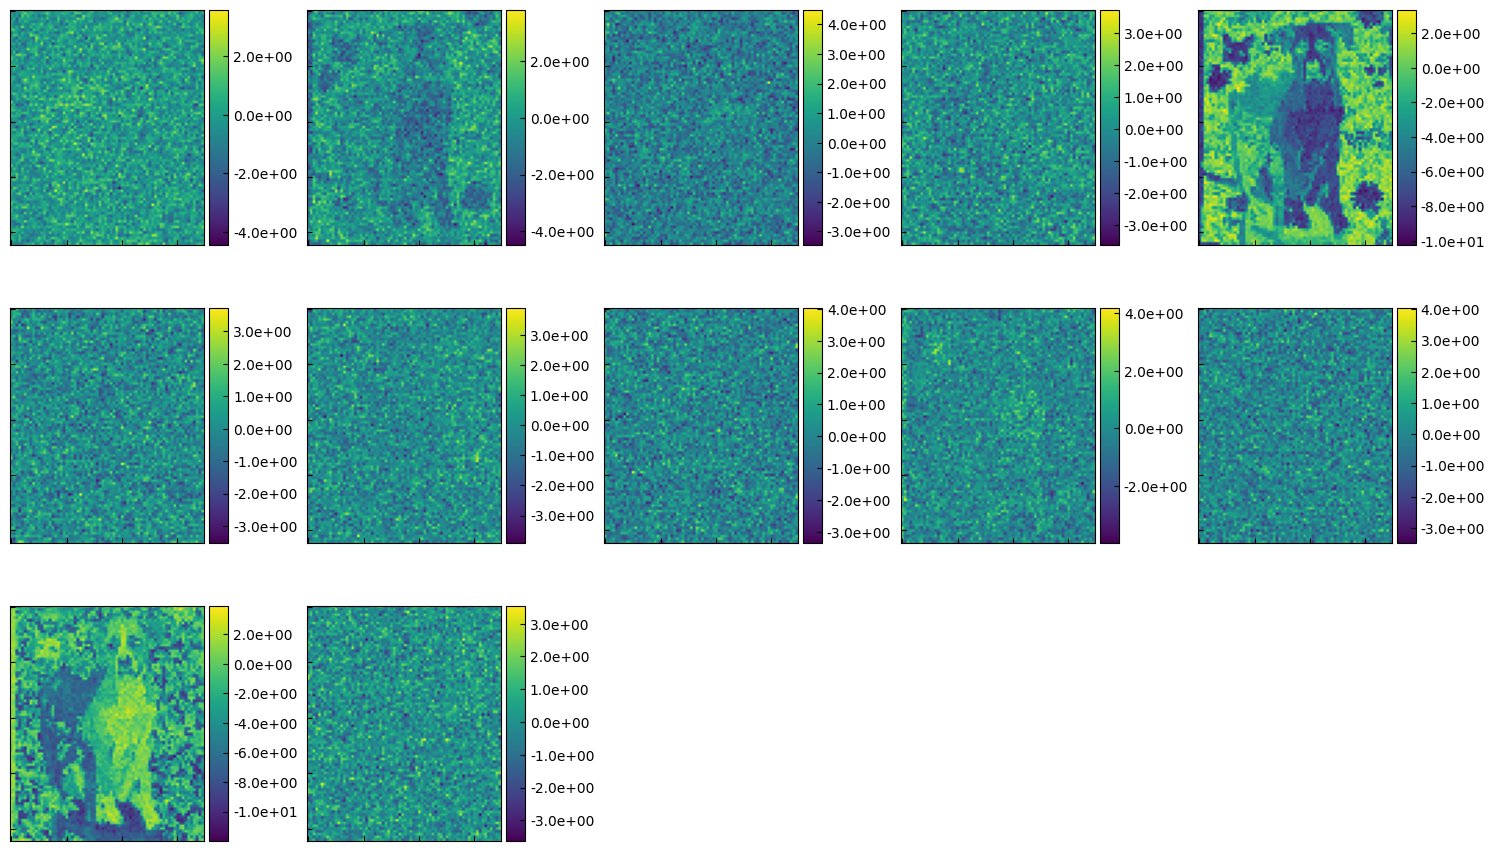

In [53]:
embedding_maps(encoded_spectra, image)

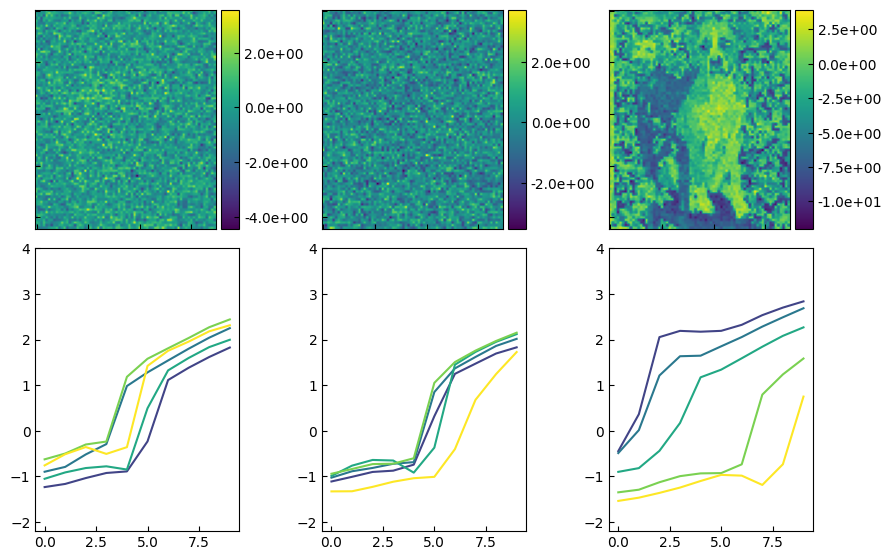

In [54]:
latent_generator(decoder, encoded_spectra, image, 5, 10, indx=[0, 5, 10], device=device)

- disentanglement with $\beta$ VAE requires careful control of optimiztion.
